# Setting



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook

In [2]:
import pandas as pd
import time
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression
import os
from calendar import monthrange
!pip install GeoPandas
import geopandas as gpd
from pandas.plotting import scatter_matrix
import datetime as dt
import keras
import tensorflow as tf

     |████████████████████████████████| 972kB 2.7MB/s 
     |████████████████████████████████| 14.8MB 295kB/s 
     |████████████████████████████████| 10.9MB 36.8MB/s 


# weather, air, time filter

In [4]:
path = '/content/drive/My Drive/air_polution/'
air_polution = pd.read_csv('/content/drive/My Drive/air_polution/6.Chulalongkorn-Hospital--Bangkok.csv', header = 0)
weather = pd.read_csv(path + 'Bangkok_weather_from_19850101.csv', header = 0)
wind = pd.read_csv(path + 'wind_2019.csv', header = 0)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
air_polution

,date,pm25,pm10,o3,no2,so2,co,aqi
0,2020-05-07 00:00:00,42,20,3.6,1.2,-,0.1,42.0
1,2020-05-06 23:00:00,42,22,4,1.8,0.6,0.1,42.0
2,2020-05-06 22:00:00,50,21,-,2.9,0.6,0.1,50.0
3,2020-05-06 21:00:00,46,21,3.6,3.5,2.2,0.1,46.0
4,2020-05-06 20:00:00,55,29,3.2,4.7,-,0.1,55.0
...,...,...,...,...,...,...,...,...
20531,2018-01-01 04:00:00,63,29,-,14.4,-,0.1,63.0
20532,2018-01-01 03:00:00,93,41,-,15.6,-,0.1,93.0
20533,2018-01-01 02:00:00,117,57,-,16.2,-,0.1,117.0
20534,2018-01-01 01:00:00,122,55,-,19,-,0.1,122.0


In [7]:
# converet number of the weather data into timestamp 
def getTime(t):
  return t[:4] + '-' + t[4:6] + '-' + t[6:8] + ' ' +t[9:11] + ':' + t[11:13] + ':00' 

In [8]:
# clean weather data
weather.columns = weather.iloc[8]
weather = weather.drop([0,1,2,3,4,5,6,7,8], axis=0)
weather['timestamp'] = weather['timestamp'].apply(getTime)
weather

8,timestamp,Bangkok Temperature [2 m elevation corrected],Bangkok Relative Humidity [2 m],Bangkok Mean Sea Level Pressure [MSL],Bangkok Precipitation Total,Bangkok Snowfall Amount,Bangkok Cloud Cover Total,Bangkok Cloud Cover High [high cld lay],Bangkok Cloud Cover Medium [mid cld lay],Bangkok Cloud Cover Low [low cld lay],Bangkok Sunshine Duration,Bangkok Shortwave Radiation,Bangkok Direct Shortwave Radiation,Bangkok Diffuse Shortwave Radiation,Bangkok Evapotranspiration,Bangkok FAO Reference Evapotranspiration [2 m],Bangkok CAPE [180-0 mb above gnd],Bangkok Wind Gust,Bangkok Wind Speed [10 m],Bangkok Wind Direction [10 m],Bangkok Wind Speed [80 m],Bangkok Wind Direction [80 m],Bangkok Wind Speed [900 mb],Bangkok Wind Direction [900 mb],Bangkok Wind Speed [850 mb],Bangkok Wind Direction [850 mb],Bangkok Wind Speed [700 mb],Bangkok Wind Direction [700 mb],Bangkok Wind Speed [500 mb],Bangkok Wind Direction [500 mb],Bangkok Geopotential Height [1000 mb],Bangkok Geopotential Height [850 mb],Bangkok Geopotential Height [700 mb],Bangkok Geopotential Height [500 mb],Bangkok Temperature [1000 mb],Bangkok Temperature [850 mb],Bangkok Temperature [700 mb],Bangkok Temperature,Bangkok Soil Temperature [0-10 cm down],Bangkok Soil Moisture [0-10 cm down],Bangkok Vapor Pressure Deficit [2 m]
9,1985-01-01 00:00:00,20.825314,58.0,1012.7,0.0,0.0,30.000002,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00144,0.030006643,0.0,22.68,6.1329885,357.51044,20.326454,22.932098,21.67487,48.366455,23.664352,56.793427,10.948973,80.537674,13.797912,97.49586,110.0,1517.0,3142.0,5846.0,25.62,15.03,8.76,20.06,25.110016,0.156,10.376534
10,1985-01-01 01:00:00,20.695314,58.0,1012.5,0.0,0.0,30.000002,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02105972,0.0,14.4,4.861344,350.5377,13.324863,38.418045,13.896187,53.426956,13.479583,55.885513,8.4042845,80.134186,19.443333,88.93908,108.0,1517.0,3138.0,5848.0,25.55,14.86,8.69,18.54,23.080017,0.155,10.293839
11,1985-01-01 02:00:00,19.775314,60.0,1012.2,0.0,0.0,30.000002,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018602137,0.0,14.759999,4.824709,353.65985,12.984975,46.123276,13.324863,51.58194,13.608762,52.52382,8.557102,75.37913,20.532627,92.009544,106.0,1513.0,3134.0,5844.0,24.78,14.81,8.7,18.09,22.49002,0.155,9.261869
12,1985-01-01 03:00:00,18.965315,62.0,1012.3,0.0,0.0,30.000002,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01641783,0.0,15.119999,4.802594,356.8202,12.538134,50.82634,13.004922,48.366455,14.336861,51.115494,8.557102,67.75098,22.065973,95.61758,106.0,1512.0,3134.0,5844.0,24.13,14.8,8.76,17.45,21.920013,0.155,8.366398
13,1985-01-01 04:00:00,18.285315,64.0,1012.3,0.0,0.0,30.000002,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012989098,0.0,14.4,4.5366287,356.63354,11.304229,52.76516,12.984975,43.876694,15.349684,50.71057,8.699793,65.55604,22.668568,100.060684,106.0,1510.0,3133.0,5843.0,23.49,14.84,8.86,16.98,21.380005,0.155,7.5959244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311068,2020-06-26 19:00:00,28.8153,77,1005.8,0,0,30,100,0,0,34.4284,23.14,16.4742,6.66576,0.0432,0.0455933,1459,14.04,6.1272,180,14.8694,186.953,11.7924,238.736,25.1537,279.058,9.51109,299.476,29.2687,121.931,52,1479,3125,5852,29.89,19.19,10.15,27.62,31.16,0.323,9.15358
311069,2020-06-26 20:00:00,28.1153,82,1006.6,0,0,30,100,2,0,0,0,0,0,0.01872,0.0127553,1530,13.68,6.1791,172.569,16.5756,177.51,11.967,248.839,24.7982,283.431,9.38765,302.471,29.3549,123.495,58,1485,3131,5856,29.41,19.21,9.96,27.38,30.61,0.323,6.87848
311070,2020-06-26 21:00:00,27.7253,85,1006.6,0,0,30,100,3,0,0,0,0,0,0.01872,0.00765578,1601,13.32,5.69498,169.216,17.3735,174.053,12.7279,261.87,25.0452,288.435,9.50427,307.304,29.5923,126.591,58,1484,3130,5855,28.97,19.23,9.86,27.12,30.16,0.322,5.60328
311071,2020-06-26 22:00:00,27.2553,88,1006.7,0,0,19.2,64,3,0,0,0,0,0,0.01296,0.00392373,1647,12.24,5.5626,163.301,17.1634,170.34,12.96,270,24.3446,293.532,9.44957,310.365,29.3637,130.525,59,1485,3130

In [9]:
def transformWind (x, weather):
  new_windD = weather[x].astype(float)
  weather[x + '(sin)'] = np.sin(new_windD * np.pi / 180.)
  weather[x + '(cos)'] = np.cos(new_windD * np.pi / 180.)
  weather.drop(columns=[x], inplace=True)

In [10]:
transformWind('Bangkok Wind Direction [10 m]', weather)
transformWind('Bangkok Wind Direction [80 m]', weather)
transformWind('Bangkok Wind Direction [900 mb]', weather)
transformWind('Bangkok Wind Direction [850 mb]', weather)
transformWind('Bangkok Wind Direction [700 mb]', weather)
transformWind('Bangkok Wind Direction [500 mb]', weather)

In [ ]:
weather

8,timestamp,Bangkok Temperature [2 m elevation corrected],Bangkok Relative Humidity [2 m],Bangkok Mean Sea Level Pressure [MSL],Bangkok Precipitation Total,Bangkok Snowfall Amount,Bangkok Cloud Cover Total,Bangkok Cloud Cover High [high cld lay],Bangkok Cloud Cover Medium [mid cld lay],Bangkok Cloud Cover Low [low cld lay],Bangkok Sunshine Duration,Bangkok Shortwave Radiation,Bangkok Direct Shortwave Radiation,Bangkok Diffuse Shortwave Radiation,Bangkok Evapotranspiration,Bangkok FAO Reference Evapotranspiration [2 m],Bangkok CAPE [180-0 mb above gnd],Bangkok Wind Gust,Bangkok Wind Speed [10 m],Bangkok Wind Speed [80 m],Bangkok Wind Speed [900 mb],Bangkok Wind Speed [850 mb],Bangkok Wind Speed [700 mb],Bangkok Wind Speed [500 mb],Bangkok Geopotential Height [1000 mb],Bangkok Geopotential Height [850 mb],Bangkok Geopotential Height [700 mb],Bangkok Geopotential Height [500 mb],Bangkok Temperature [1000 mb],Bangkok Temperature [850 mb],Bangkok Temperature [700 mb],Bangkok Temperature,Bangkok Soil Temperature [0-10 cm down],Bangkok Soil Moisture [0-10 cm down],Bangkok Vapor Pressure Deficit [2 m],Bangkok Wind Direction [10 m](sin),Bangkok Wind Direction [10 m](cos),Bangkok Wind Direction [80 m](sin),Bangkok Wind Direction [80 m](cos),Bangkok Wind Direction [900 mb](sin),Bangkok Wind Direction [900 mb](cos),Bangkok Wind Direction [850 mb](sin),Bangkok Wind Direction [850 mb](cos),Bangkok Wind Direction [700 mb](sin),Bangkok Wind Direction [700 mb](cos),Bangkok Wind Direction [500 mb](sin),Bangkok Wind Direction [500 mb](cos)
9,1985-01-01 00:00:00,20.825314,58.0,1012.7,0.0,0.0,30.000002,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00144,0.030006643,0.0,22.68,6.1329885,20.326454,21.67487,23.664352,10.948973,13.797912,110.0,1517.0,3142.0,5846.0,25.62,15.03,8.76,20.06,25.110016,0.156,10.376534,-4.343735e-02,0.999056,0.389640,0.920967,0.747409,6.643639e-01,0.836701,0.547659,0.986394,0.164399,0.991454,-0.130455
10,1985-01-01 01:00:00,20.695314,58.0,1012.5,0.0,0.0,30.000002,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02105972,0.0,14.4,4.861344,13.324863,13.896187,13.479583,8.4042845,19.443333,108.0,1517.0,3138.0,5848.0,25.55,14.86,8.69,18.54,23.080017,0.155,10.293839,-1.643986e-01,0.986394,0.621395,0.783498,0.803098,5.958471e-01,0.827919,0.560848,0.985212,0.171341,0.999829,0.018515
11,1985-01-01 02:00:00,19.775314,60.0,1012.2,0.0,0.0,30.000002,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018602137,0.0,14.759999,4.824709,12.984975,13.324863,13.608762,8.557102,20.532627,106.0,1513.0,3134.0,5844.0,24.78,14.81,8.7,18.09,22.49002,0.155,9.261869,-1.104308e-01,0.993884,0.720833,0.693109,0.783498,6.213948e-01,0.793606,0.608432,0.967617,0.252422,0.999385,-0.035066
12,1985-01-01 03:00:00,18.965315,62.0,1012.3,0.0,0.0,30.000002,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01641783,0.0,15.119999,4.802594,12.538134,13.004922,14.336861,8.557102,22.065973,106.0,1512.0,3134.0,5844.0,24.13,14.8,8.76,17.45,21.920013,0.155,8.366398,-5.546949e-02,0.998460,0.775235,0.631673,0.747409,6.643639e-01,0.778413,0.627753,0.925547,0.378633,0.995197,-0.097888
13,1985-01-01 04:00:00,18.285315,64.0,1012.3,0.0,0.0,30.000002,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012989098,0.0,14.4,4.5366287,11.304229,12.984975,15.349684,8.699793,22.668568,106.0,1510.0,3133.0,5843.0,23.49,14.84,8.86,16.98,21.380005,0.155,7.5959244,-5.872201e-02,0.998274,0.796162,0.605083,0.693109,7.208331e-01,0.773957,0.633238,0.910366,0.413803,0.984623,-0.174691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311068,2020-06-26 19:00:00,28.8153,77,1005.8,0,0,30,100,0,0,34.4284,23.14,16.4742,6.66576,0.0432,0.0455933,1459,14.04,6.1272,14.8694,11.7924,25.1537,9.51109,29.2687,52,1479,3125,5852,29.89,19.19,10.15,27.62,31.16,0.323,9.15358,1.224647e-16,-1.000000,-0.121054,-0.992646,-0.854788,-5.189781e-01,-0.987530,0.157432,-0.870563,0.492057,0.848689,-0.528893
311069,2020-06-26 20:00:00,28.1153,82,1006.6,0,0,30

In [13]:
def filter_data(data, time):
  data.rename(columns={time: 'timestamp'},inplace=True)
  data.timestamp = pd.to_datetime(data['timestamp'])
  data = data.sort_values(["timestamp"])
  d1 = '2019-01-01' + ' 00:00:00'
  d2 = '2019-12-31' + ' 23:59:59'
  mask = (data['timestamp'] > pd.Timestamp(d1)) & (data['timestamp'] <= pd.Timestamp(d2))
  data = pd.DataFrame(data.loc[mask]).reset_index()
  return data

In [14]:
# ap_Dind = air_polution[air_polution['station'] == 'National Housing Authority Dindaeng']
ap_Dind =  filter_data(air_polution, 'date')
weather = filter_data(weather, 'time')
wind = filter_data(wind, 'local_time')

In [15]:
ap_Dind

,index,timestamp,pm25,pm10,o3,no2,so2,co,aqi
0,11791,2019-01-01 01:00:00,74,38,-,-,-,-,74.0
1,11790,2019-01-01 02:00:00,80,44,-,12.1,-,0.1,80.0
2,11789,2019-01-01 03:00:00,65,37,-,17.3,-,0.1,65.0
3,11788,2019-01-01 04:00:00,65,36,-,10.4,-,0.1,65.0
4,11787,2019-01-01 05:00:00,57,31,-,16.2,-,0.1,57.0
...,...,...,...,...,...,...,...,...,...
8752,3039,2019-12-31 19:00:00,68,30,-,19,-,0.1,68.0
8753,3038,2019-12-31 20:00:00,82,36,-,19.6,-,0.1,82.0
8754,3037,2019-12-31 21:00:00,80,39,-,20.8,-,0.1,80.0
8755,3036,2019-12-31 22:00:00,87,42,-,20.8,-,0.1,87.0


In [16]:
weather

8,index,timestamp,Bangkok Temperature [2 m elevation corrected],Bangkok Relative Humidity [2 m],Bangkok Mean Sea Level Pressure [MSL],Bangkok Precipitation Total,Bangkok Snowfall Amount,Bangkok Cloud Cover Total,Bangkok Cloud Cover High [high cld lay],Bangkok Cloud Cover Medium [mid cld lay],Bangkok Cloud Cover Low [low cld lay],Bangkok Sunshine Duration,Bangkok Shortwave Radiation,Bangkok Direct Shortwave Radiation,Bangkok Diffuse Shortwave Radiation,Bangkok Evapotranspiration,Bangkok FAO Reference Evapotranspiration [2 m],Bangkok CAPE [180-0 mb above gnd],Bangkok Wind Gust,Bangkok Wind Speed [10 m],Bangkok Wind Speed [80 m],Bangkok Wind Speed [900 mb],Bangkok Wind Speed [850 mb],Bangkok Wind Speed [700 mb],Bangkok Wind Speed [500 mb],Bangkok Geopotential Height [1000 mb],Bangkok Geopotential Height [850 mb],Bangkok Geopotential Height [700 mb],Bangkok Geopotential Height [500 mb],Bangkok Temperature [1000 mb],Bangkok Temperature [850 mb],Bangkok Temperature [700 mb],Bangkok Temperature,Bangkok Soil Temperature [0-10 cm down],Bangkok Soil Moisture [0-10 cm down],Bangkok Vapor Pressure Deficit [2 m],Bangkok Wind Direction [10 m](sin),Bangkok Wind Direction [10 m](cos),Bangkok Wind Direction [80 m](sin),Bangkok Wind Direction [80 m](cos),Bangkok Wind Direction [900 mb](sin),Bangkok Wind Direction [900 mb](cos),Bangkok Wind Direction [850 mb](sin),Bangkok Wind Direction [850 mb](cos),Bangkok Wind Direction [700 mb](sin),Bangkok Wind Direction [700 mb](cos),Bangkok Wind Direction [500 mb](sin),Bangkok Wind Direction [500 mb](cos)
0,298042,2019-01-01 01:00:00,23.9553,57,1016,0,0,0,0,0,0,0,0,0,0,0.01728,0.0480429,0,17.28,7.992,22.4935,29.0241,14.6896,8.22504,21.9865,139,1544,3171,5880,25.28,16.51,7.54,23.15,28.36,0.257,12.8496,0.600000,8.000001e-01,0.768221,6.401844e-01,0.868243,0.496139,0.808736,0.588172,-0.919145,0.393919,-0.769561,0.638573
1,298043,2019-01-01 02:00:00,22.5553,62,1015.8,0,0,0.9,3,0,0,0,0,0,0,0.01296,0.0366013,0,22.32,7.50662,20.1504,27.258,16.642,6.92474,22.7257,137,1540,3166,5873,24.69,16.68,7.27,22.03,27.53,0.257,10.4351,0.461353,8.872168e-01,0.661030,7.503591e-01,0.832050,0.554700,0.778754,0.627330,-0.883788,0.467888,-0.760374,0.649486
2,298044,2019-01-01 03:00:00,21.4453,67,1015.7,0,0,6.9,23,0,0,0,0,0,0,0.01152,0.0279545,0,23.4,7.24686,18.5146,25.364,18.6263,6.19367,23.1998,136,1538,3164,5869,24.1,16.88,7.08,21.08,26.73,0.257,8.46917,0.294086,9.557790e-01,0.447213,8.944273e-01,0.823213,0.567733,0.753773,0.657135,-0.813733,0.581239,-0.744835,0.667248
3,298045,2019-01-01 04:00:00,20.5253,71,1015.6,0,0,6.3,21,0,0,0,0,0,0,0.01008,0.0227983,0,21.96,7.31509,19.2423,24.5751,20.9729,5.86038,23.4249,134,1535,3162,5866,23.34,17.03,6.9,20.26,25.92,0.257,7.03359,0.182089,9.832820e-01,0.299340,9.541465e-01,0.849640,0.527363,0.772425,0.635106,-0.675725,0.737154,-0.722308,0.691572
4,298046,2019-01-01 05:00:00,19.8453,74,1015.9,0,0,9,30,0,0,0,0,0,0,0.01008,0.0188045,0,21.96,7.31509,19.1376,24.7354,22.4733,5.90444,23.9339,137,1537,3163,5867,22.42,17.1,6.75,19.61,25.18,0.257,6.04639,0.182089,9.832820e-01,0.282166,9.593656e-01,0.931457,0.363851,0.816968,0.576683,-0.609710,0.792624,-0.691905,0.721988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8754,306796,2019-12-31 19:00:00,30.4153,49,1012.4,0,0,10,4,0,10,2.41277,0,0,0,0.00144,0.0381273,191,11.52,4.86134,17.0155,25.1485,24.9753,27.1937,18.2183,110,1542,3175,5878,31.87,19.04,7.87,27.13,33.31,0.135,22.2542,0.986394,-1.643989e-01,0.994389,-1.057861e-01,0.973417,0.229039,0.965755,0.259457,0.992877,-0.119145,-0.612572,-0.790415
8755,306797,2019-12-31 20:00:00,29.5653,53,1013,0,0,10,2,0,10,0,0,0,0,0.00288,0.0178277,176,14.04,3.2409,16.3948,27.6849,27.9435,27.7574,18.7235,115,1547,3179,5881,31.4,19.05,7.44,26.22,32.22,0.135,19.5326,0.986394,-1.643989e-01,0.988116,-1.537069e-01,0.975260,0.221059,0.966235,0.257663,0.985684,-0.168604,-0.6

In [17]:
wind

,index,timestamp,electricity,wind_speed
0,1,2019-01-01 01:00:00,0.087,4.465
1,2,2019-01-01 02:00:00,0.076,4.291
2,3,2019-01-01 03:00:00,0.071,4.216
3,4,2019-01-01 04:00:00,0.041,3.639
4,5,2019-01-01 05:00:00,0.032,3.429
...,...,...,...,...
8754,8755,2019-12-31 19:00:00,0.018,3.026
8755,8756,2019-12-31 20:00:00,0.016,2.945
8756,8757,2019-12-31 21:00:00,0.021,3.110
8757,8758,2019-12-31 22:00:00,0.032,3.442


In [18]:
data = pd.merge(ap_Dind,weather,how='inner',on='timestamp',validate='many_to_many')
data = pd.merge(data,wind,how='inner',on='timestamp',validate='many_to_many')

In [19]:
file_path = '/content/drive/My Drive/air_polution/AQI_weather.csv'
data.to_csv(file_path, index = False)

# Traffic filter

In [3]:
def clean_data(data, mon, lat_min, lat_max, lon_min, lon_max):
  data.timestamp = pd.to_datetime(data.timestamp, errors = 'coerce')
  data = data[data['engine_acc'] == 1]
  data = data[data['gpsvalid'] == 1]
  # data = data[data['timestamp'] != '2019-0101 00:00:00']
  data = data.drop(columns=['gpsvalid', 'engine_acc'])
  data = data[(data['lat'] <=  lat_max) & (lat_min <= data['lat'])]
  data = data[(data['lon'] <=  lon_max) & (lon_min <= data['lon'])]
  # data = data[data['timestamp'] != '2019-0101 00:00:00']
  data.timestamp = pd.to_datetime(data.timestamp)
  
  data = data.sort_values(["timestamp"])
  i = 1
  d1 = '2019-' + str(100+mon)[1:] + '-' + str(100+i)[1:] + ' 00:00:00'
  i = monthrange(2019, mon)[-1]
  d2 = '2019-' + str(100+mon)[1:] + '-' + str(100+i)[1:] + ' 23:59:59'
  mask = (data['timestamp'] > pd.Timestamp(d1)) & (data['timestamp'] <= pd.Timestamp(d2))
  data = pd.DataFrame(data.loc[mask])
  return data
# data = clean_data(data, mon)

In [4]:
area = [[2,[13.713035, 13.748834, 100.518506, 100.554335]],
        [5,[13.686119, 13.776057, 100.490697, 100.583254]],
        [10,[13.641285, 13.820671, 100.444445, 100.629641]]]
def Extract_points_from_selected_district(mon, radius):
  for i in range(3):
    if (radius == area[i][0]):
      lat_min = area[i][1][0]
      lat_max = area[i][1][1]
      lon_min = area[i][1][2]
      lon_max = area[i][1][3]
  n_days = monthrange(2019, mon)[-1]
  comb = []
  for i in range(1,n_days + 1):
    if (mon == 7 and 16<i and i<22):
      continue
    print('working on'+ str(i))
    G_path = '/content/drive/My Drive/air_polution/PROBE-2019' + str(100+mon)[1:] + '/'
    file_path = G_path + '2019' + str(100+mon)[1:] +str(100 + i)[1:] + '.csv'
    data = pd.read_csv(file_path, header = None, names = ['VehicleID', 'gpsvalid', 'lat', 'lon', 'timestamp', 'speed', 'heading', 'for_hire_light', 'engine_acc'])
    # Remove invalid data points
    # print(data.timestamp)
    data = clean_data(data, mon, lat_min, lat_max, lon_min, lon_max)
    # convert Pandas into GeoPandas
    # gdf = gpd.GeoDataFrame(data, geometry = gpd.points_from_xy(data.lon, data.lat))
    # # Extract points in selected district
    # print(data.lon.min,data.lon.max)
    # bk_dist_pt = gdf.cx[lat_min:lat_max, lon_min:lon_max]
    print()
    # out = pd.DataFrame(bk_dist_pt)
    comb.append(data)
    # print(out)
  out_comb = pd.concat(comb, axis=0)
  out_path = '/content/drive/My Drive/air_polution/filted' + str(100+mon)[1:] + '_' + str(radius) + 'km.csv'
  out_comb.to_csv(out_path, index = False)

In [ ]:
radiusss = [2, 5, 10]
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
for month in months:
  for i in radiusss:
    Extract_points_from_selected_district(month, i)

In [6]:

def mergeMonth(start, end, distance):
  frames = []
  for i in range(end-start+1):
    file_path = '/content/drive/My Drive/air_polution/filted' + str(100+start)[1:] + '_' + str(distance) + 'km.csv'
    data = pd.read_csv(file_path)
    data.timestamp = pd.to_datetime(data.timestamp)
    data['timestamp'] = data['timestamp'].dt.floor('H')
    data = data.groupby('timestamp') \
           .agg({'speed':'mean', 'VehicleID':'size'}) \
           .rename(columns={'speed':'Avg_speed_'+str(distance)+'km','VehicleID':'num_cars_'+str(distance)+'km'}) \
           .reset_index()
    frames.append(data)
    start += 1
  data = pd.concat(frames)
  return data

In [7]:
data_2km = mergeMonth(1, 12, 2)
data_5km = mergeMonth(1, 12, 5)
data_10km = mergeMonth(1, 12, 10)

In [8]:
data = pd.merge(data_2km,data_5km,how='inner',on='timestamp',validate='many_to_many')
data = pd.merge(data,data_10km,how='inner',on='timestamp',validate='many_to_many')

In [9]:
file_path_merge_May_Sep_5km =  '/content/drive/My Drive/air_polution/AQI_weather.csv'
df = pd.read_csv(file_path_merge_May_Sep_5km)
df

,index_x,timestamp,pm25,pm10,o3,no2,so2,co,aqi,index_y,Bangkok Temperature [2 m elevation corrected],Bangkok Relative Humidity [2 m],Bangkok Mean Sea Level Pressure [MSL],Bangkok Precipitation Total,Bangkok Snowfall Amount,Bangkok Cloud Cover Total,Bangkok Cloud Cover High [high cld lay],Bangkok Cloud Cover Medium [mid cld lay],Bangkok Cloud Cover Low [low cld lay],Bangkok Sunshine Duration,Bangkok Shortwave Radiation,Bangkok Direct Shortwave Radiation,Bangkok Diffuse Shortwave Radiation,Bangkok Evapotranspiration,Bangkok FAO Reference Evapotranspiration [2 m],Bangkok CAPE [180-0 mb above gnd],Bangkok Wind Gust,Bangkok Wind Speed [10 m],Bangkok Wind Speed [80 m],Bangkok Wind Speed [900 mb],Bangkok Wind Speed [850 mb],Bangkok Wind Speed [700 mb],Bangkok Wind Speed [500 mb],Bangkok Geopotential Height [1000 mb],Bangkok Geopotential Height [850 mb],Bangkok Geopotential Height [700 mb],Bangkok Geopotential Height [500 mb],Bangkok Temperature [1000 mb],Bangkok Temperature [850 mb],Bangkok Temperature [700 mb],Bangkok Temperature,Bangkok Soil Temperature [0-10 cm down],Bangkok Soil Moisture [0-10 cm down],Bangkok Vapor Pressure Deficit [2 m],Bangkok Wind Direction [10 m](sin),Bangkok Wind Direction [10 m](cos),Bangkok Wind Direction [80 m](sin),Bangkok Wind Direction [80 m](cos),Bangkok Wind Direction [900 mb](sin),Bangkok Wind Direction [900 mb](cos),Bangkok Wind Direction [850 mb](sin),Bangkok Wind Direction [850 mb](cos),Bangkok Wind Direction [700 mb](sin),Bangkok Wind Direction [700 mb](cos),Bangkok Wind Direction [500 mb](sin),Bangkok Wind Direction [500 mb](cos),index,electricity,wind_speed
0,11791,2019-01-01 01:00:00,74,38,-,-,-,-,74.0,298042,23.955315,57.0,1016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.01728,0.048043,0.0,17.280000,7.992000,22.493519,29.024128,14.689588,8.225035,21.986542,139.0,1544.0,3171.0,5880.0,25.28,16.51,7.54,23.15,28.360016,0.257,12.849623,0.600000,8.000001e-01,0.768221,6.401844e-01,0.868243,0.496139,0.808736,0.588172,-0.919145,0.393919,-0.769561,0.638573,1,0.087,4.465
1,11790,2019-01-01 02:00:00,80,44,-,12.1,-,0.1,80.0,298043,22.555315,62.0,1015.8,0.0,0.0,0.9,3.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.01296,0.036601,0.0,22.319998,7.506620,20.150354,27.257967,16.641972,6.924738,22.725668,137.0,1540.0,3166.0,5873.0,24.69,16.68,7.27,22.03,27.529999,0.257,10.435104,0.461353,8.872168e-01,0.661030,7.503591e-01,0.832050,0.554700,0.778754,0.627330,-0.883788,0.467888,-0.760374,0.649486,2,0.076,4.291
2,11789,2019-01-01 03:00:00,65,37,-,17.3,-,0.1,65.0,298044,21.445314,67.0,1015.7,0.0,0.0,6.9,23.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.01152,0.027955,0.0,23.400000,7.246862,18.514643,25.364037,18.626305,6.193674,23.199759,136.0,1538.0,3164.0,5869.0,24.10,16.88,7.08,21.08,26.730011,0.257,8.469172,0.294086,9.557790e-01,0.447213,8.944273e-01,0.823213,0.567733,0.753773,0.657135,-0.813733,0.581239,-0.744835,0.667248,3,0.071,4.216
3,11788,2019-01-01 04:00:00,65,36,-,10.4,-,0.1,65.0,298045,20.525314,71.0,1015.6,0.0,0.0,6.3,21.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.01008,0.022798,0.0,21.960000,7.315093,19.242327,24.575110,20.972897,5.860375,23.424908,134.0,1535.0,3162.0,5866.0,23.34,17.03,6.90,20.26,25.920013,0.257,7.033592,0.182089,9.832820e-01,0.299340,9.541465e-01,0.849640,0.527363,0.772425,0.635106,-0.675725,0.737154,-0.722308,0.691572,4,0.041,3.639
4,11787,2019-01-01 05:00:00,57,31,-,16.2,-,0.1,57.0,298046,19.845314,74.0,1015.9,0.0,0.0,9.0,30.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.01008,0.018804,0.0,21.960000,7.315093,19.137648,24.735432,22.473343,5.904439,23.933908,137.0,1537.0,3163.0,5867.0,22.42,17.10,6.75,19.61,25.179993,0.257,6.046389,0.182089,9.832820e-01,0.282166,9.593656e-01,0.931457,0.363851,0.816968,0.576683,-0.609710,0.792624,-0.691905,0.721988,5,0.032,3.429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8752,3039,2019-12-31 19:00:00,6

In [17]:
data = pd.merge(data,df,how='inner',on='timestamp',validate='many_to_many')
# data = pd.merge(data,weather,how='inner',on='timestamp',validate='many_to_many')
# data = pd.merge(data,wind,how='inner',on='timestamp',validate='many_to_many')

In [16]:
df.timestamp = pd.to_datetime(df['timestamp'])

In [18]:
data

,timestamp,Avg_speed_2km,num_cars_2km,Avg_speed_5km,num_cars_5km,Avg_speed_10km,num_cars_10km,index_x,pm25,pm10,o3,no2,so2,co,aqi,index_y,Bangkok Temperature [2 m elevation corrected],Bangkok Relative Humidity [2 m],Bangkok Mean Sea Level Pressure [MSL],Bangkok Precipitation Total,Bangkok Snowfall Amount,Bangkok Cloud Cover Total,Bangkok Cloud Cover High [high cld lay],Bangkok Cloud Cover Medium [mid cld lay],Bangkok Cloud Cover Low [low cld lay],Bangkok Sunshine Duration,Bangkok Shortwave Radiation,Bangkok Direct Shortwave Radiation,Bangkok Diffuse Shortwave Radiation,Bangkok Evapotranspiration,Bangkok FAO Reference Evapotranspiration [2 m],Bangkok CAPE [180-0 mb above gnd],Bangkok Wind Gust,Bangkok Wind Speed [10 m],Bangkok Wind Speed [80 m],Bangkok Wind Speed [900 mb],Bangkok Wind Speed [850 mb],Bangkok Wind Speed [700 mb],Bangkok Wind Speed [500 mb],Bangkok Geopotential Height [1000 mb],Bangkok Geopotential Height [850 mb],Bangkok Geopotential Height [700 mb],Bangkok Geopotential Height [500 mb],Bangkok Temperature [1000 mb],Bangkok Temperature [850 mb],Bangkok Temperature [700 mb],Bangkok Temperature,Bangkok Soil Temperature [0-10 cm down],Bangkok Soil Moisture [0-10 cm down],Bangkok Vapor Pressure Deficit [2 m],Bangkok Wind Direction [10 m](sin),Bangkok Wind Direction [10 m](cos),Bangkok Wind Direction [80 m](sin),Bangkok Wind Direction [80 m](cos),Bangkok Wind Direction [900 mb](sin),Bangkok Wind Direction [900 mb](cos),Bangkok Wind Direction [850 mb](sin),Bangkok Wind Direction [850 mb](cos),Bangkok Wind Direction [700 mb](sin),Bangkok Wind Direction [700 mb](cos),Bangkok Wind Direction [500 mb](sin),Bangkok Wind Direction [500 mb](cos),index,electricity,wind_speed
0,2019-01-01 01:00:00,18.565386,3097,20.916341,16101,26.393900,31739,11791,74,38,-,-,-,-,74.0,298042,23.955315,57.0,1016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.01728,0.048043,0.0,17.280000,7.992000,22.493519,29.024128,14.689588,8.225035,21.986542,139.0,1544.0,3171.0,5880.0,25.28,16.51,7.54,23.15,28.360016,0.257,12.849623,0.600000,8.000001e-01,0.768221,6.401844e-01,0.868243,0.496139,0.808736,0.588172,-0.919145,0.393919,-0.769561,0.638573,1,0.087,4.465
1,2019-01-01 02:00:00,22.872611,2355,25.613285,11140,30.391756,25715,11790,80,44,-,12.1,-,0.1,80.0,298043,22.555315,62.0,1015.8,0.0,0.0,0.9,3.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.01296,0.036601,0.0,22.319998,7.506620,20.150354,27.257967,16.641972,6.924738,22.725668,137.0,1540.0,3166.0,5873.0,24.69,16.68,7.27,22.03,27.529999,0.257,10.435104,0.461353,8.872168e-01,0.661030,7.503591e-01,0.832050,0.554700,0.778754,0.627330,-0.883788,0.467888,-0.760374,0.649486,2,0.076,4.291
2,2019-01-01 03:00:00,23.259295,2098,26.335067,9804,31.385424,22845,11789,65,37,-,17.3,-,0.1,65.0,298044,21.445314,67.0,1015.7,0.0,0.0,6.9,23.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.01152,0.027955,0.0,23.400000,7.246862,18.514643,25.364037,18.626305,6.193674,23.199759,136.0,1538.0,3164.0,5869.0,24.10,16.88,7.08,21.08,26.730011,0.257,8.469172,0.294086,9.557790e-01,0.447213,8.944273e-01,0.823213,0.567733,0.753773,0.657135,-0.813733,0.581239,-0.744835,0.667248,3,0.071,4.216
3,2019-01-01 04:00:00,25.040327,1711,28.187279,8207,32.356202,19065,11788,65,36,-,10.4,-,0.1,65.0,298045,20.525314,71.0,1015.6,0.0,0.0,6.3,21.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.01008,0.022798,0.0,21.960000,7.315093,19.242327,24.575110,20.972897,5.860375,23.424908,134.0,1535.0,3162.0,5866.0,23.34,17.03,6.90,20.26,25.920013,0.257,7.033592,0.182089,9.832820e-01,0.299340,9.541465e-01,0.849640,0.527363,0.772425,0.635106,-0.675725,0.737154,-0.722308,0.691572,4,0.041,3.639
4,2019-01-01 05:00:00,26.249147,1465,29.381196,7041,32.442185,17651,11787,57,31,-,16.2,-,0.1,57.0,298046,19.845314,74.0,1015.9,0.0,0.0,9.0,30.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.01008,0.018804,0.0,21.960000,7.315093,19.137648,24.735432,22.473343,5.904439,23.933908,137.0,1537.0,3163.0,5867.0,22.42,17.10,6.75,19.61,25.179993,0.257,6.046389,0.182089,9.832820e-01,0.282166,9.593656e-01,0.931457,0.363851,0.816968,0.576683,-0.60971

In [25]:
out_path = '/content/drive/My Drive/air_polution/merge_May_Dec_all.csv'
data.to_csv(out_path, index = False)

In [20]:
file_path_merge_May_Sep_5km = '/content/drive/My Drive/air_polution/merge_May_Dec_all.csv'
data = pd.read_csv(file_path_merge_May_Sep_5km)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
data = data.drop(columns={'pm25','pm10','o3','no2','so2','co','index_x', 'index_y', 'index', 'Bangkok Snowfall Amount'
, 'Bangkok Cloud Cover High [high cld lay]', 'Bangkok Cloud Cover Medium [mid cld lay]',	'Bangkok Cloud Cover Low [low cld lay]'}) 

In [24]:
data

,timestamp,Avg_speed_2km,num_cars_2km,Avg_speed_5km,num_cars_5km,Avg_speed_10km,num_cars_10km,aqi,Bangkok Temperature [2 m elevation corrected],Bangkok Relative Humidity [2 m],Bangkok Mean Sea Level Pressure [MSL],Bangkok Precipitation Total,Bangkok Cloud Cover Total,Bangkok Sunshine Duration,Bangkok Shortwave Radiation,Bangkok Direct Shortwave Radiation,Bangkok Diffuse Shortwave Radiation,Bangkok Evapotranspiration,Bangkok FAO Reference Evapotranspiration [2 m],Bangkok CAPE [180-0 mb above gnd],Bangkok Wind Gust,Bangkok Wind Speed [10 m],Bangkok Wind Speed [80 m],Bangkok Wind Speed [900 mb],Bangkok Wind Speed [850 mb],Bangkok Wind Speed [700 mb],Bangkok Wind Speed [500 mb],Bangkok Geopotential Height [1000 mb],Bangkok Geopotential Height [850 mb],Bangkok Geopotential Height [700 mb],Bangkok Geopotential Height [500 mb],Bangkok Temperature [1000 mb],Bangkok Temperature [850 mb],Bangkok Temperature [700 mb],Bangkok Temperature,Bangkok Soil Temperature [0-10 cm down],Bangkok Soil Moisture [0-10 cm down],Bangkok Vapor Pressure Deficit [2 m],Bangkok Wind Direction [10 m](sin),Bangkok Wind Direction [10 m](cos),Bangkok Wind Direction [80 m](sin),Bangkok Wind Direction [80 m](cos),Bangkok Wind Direction [900 mb](sin),Bangkok Wind Direction [900 mb](cos),Bangkok Wind Direction [850 mb](sin),Bangkok Wind Direction [850 mb](cos),Bangkok Wind Direction [700 mb](sin),Bangkok Wind Direction [700 mb](cos),Bangkok Wind Direction [500 mb](sin),Bangkok Wind Direction [500 mb](cos),electricity,wind_speed
0,2019-01-01 01:00:00,18.565386,3097,20.916341,16101,26.393900,31739,74.0,23.955315,57.0,1016.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.01728,0.048043,0.0,17.280000,7.992000,22.493519,29.024128,14.689588,8.225035,21.986542,139.0,1544.0,3171.0,5880.0,25.28,16.51,7.54,23.15,28.360016,0.257,12.849623,0.600000,8.000001e-01,0.768221,6.401844e-01,0.868243,0.496139,0.808736,0.588172,-0.919145,0.393919,-0.769561,0.638573,0.087,4.465
1,2019-01-01 02:00:00,22.872611,2355,25.613285,11140,30.391756,25715,80.0,22.555315,62.0,1015.8,0.0,0.9,0.000000,0.0,0.0,0.0,0.01296,0.036601,0.0,22.319998,7.506620,20.150354,27.257967,16.641972,6.924738,22.725668,137.0,1540.0,3166.0,5873.0,24.69,16.68,7.27,22.03,27.529999,0.257,10.435104,0.461353,8.872168e-01,0.661030,7.503591e-01,0.832050,0.554700,0.778754,0.627330,-0.883788,0.467888,-0.760374,0.649486,0.076,4.291
2,2019-01-01 03:00:00,23.259295,2098,26.335067,9804,31.385424,22845,65.0,21.445314,67.0,1015.7,0.0,6.9,0.000000,0.0,0.0,0.0,0.01152,0.027955,0.0,23.400000,7.246862,18.514643,25.364037,18.626305,6.193674,23.199759,136.0,1538.0,3164.0,5869.0,24.10,16.88,7.08,21.08,26.730011,0.257,8.469172,0.294086,9.557790e-01,0.447213,8.944273e-01,0.823213,0.567733,0.753773,0.657135,-0.813733,0.581239,-0.744835,0.667248,0.071,4.216
3,2019-01-01 04:00:00,25.040327,1711,28.187279,8207,32.356202,19065,65.0,20.525314,71.0,1015.6,0.0,6.3,0.000000,0.0,0.0,0.0,0.01008,0.022798,0.0,21.960000,7.315093,19.242327,24.575110,20.972897,5.860375,23.424908,134.0,1535.0,3162.0,5866.0,23.34,17.03,6.90,20.26,25.920013,0.257,7.033592,0.182089,9.832820e-01,0.299340,9.541465e-01,0.849640,0.527363,0.772425,0.635106,-0.675725,0.737154,-0.722308,0.691572,0.041,3.639
4,2019-01-01 05:00:00,26.249147,1465,29.381196,7041,32.442185,17651,57.0,19.845314,74.0,1015.9,0.0,9.0,0.000000,0.0,0.0,0.0,0.01008,0.018804,0.0,21.960000,7.315093,19.137648,24.735432,22.473343,5.904439,23.933908,137.0,1537.0,3163.0,5867.0,22.42,17.10,6.75,19.61,25.179993,0.257,6.046389,0.182089,9.832820e-01,0.282166,9.593656e-01,0.931457,0.363851,0.816968,0.576683,-0.609710,0.792624,-0.691905,0.721988,0.032,3.429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8588,2019-12-31 19:00:00,18.119312,4593,18.314281,23409,23.467039,42065,68.0,30.415314,49.0,1012.4,0.0,10.0,2.412766,0.0,0.0,0.0,0.00144,0.038127,191.0,11.519999,4.861344,17.015474,

In [ ]:
def incoporateHistoric (colName, H, df):
  for i in range(len(df)):
    result = 0;
    # let the first few row run at first
    if (i <= H):
      if (i == 0):
        df.loc[df.index[i], colName + '(past %s hours average)' % (H)] = df.loc[df.index[i],colName]
      else:
        for k in range(i):
          row_data = float(df.loc[df.index[k],colName])
          result += row_data
        df.loc[df.index[i], colName + '(past %s hours average)' % (H)] = result / i
      continue
    
    for j in range(H):
      row_data = float(df.loc[df.index[i-j],colName])
      result += row_data
    df.loc[df.index[i], colName + '(past %s hours average)' % (H)] = result / H

In [ ]:
cols = data.columns
for col in cols:
  if (col == 'timestamp'):
    continue
  incoporateHistoric(col, 3, data)
  incoporateHistoric(col, 8, data)
  incoporateHistoric(col, 24, data)
  incoporateHistoric(col, 48, data)

In [ ]:
out_path = '/content/drive/My Drive/air_polution/merge_May_Dec_all_historic.csv'
data.to_csv(out_path, index = False)

# Time filter

In [ ]:
file_path_merge_May_Sep_5km = '/content/drive/My Drive/air_polution/merge_May_Dec_all_historic.csv'
data = pd.read_csv(file_path_merge_May_Sep_5km)

In [ ]:
def timeFilter(df):
  r = 0
  data.timestamp = pd.to_datetime(data.timestamp)
  for i in range(len(df)):
    hour = df.loc[df.index[i],'timestamp'].hour
    date = df.loc[df.index[i],'timestamp'].day
    month = df.loc[df.index[i],'timestamp'].month
    day = df.loc[df.index[i],'timestamp'].dayofweek
    df.loc[df.index[i], 'hour of the day (sin)'] = np.sin(hour * 15 * np.pi / 180.)
    df.loc[df.index[i], 'hour of the day (cos)'] = np.cos(hour * 15 * np.pi / 180.)
    df.loc[df.index[i], 'month (sin)'] = np.sin(month * 30 * np.pi / 180.)
    df.loc[df.index[i], 'month (cos)'] = np.cos(month * 30 * np.pi / 180.)
    
    # mark national holiday first
    if (((month == 1) and (date == 1)) or ((month == 2) and (date == 19)) or ((month == 4) and (date == 8)) or ((month == 4) and (date == 13)) or ((month == 4) and (date == 14)) or ((month == 4) and (date == 15)) or ((month == 4) and (date == 16))
        or ((month == 5) and (date == 1)) or ((month == 5) and (date == 6)) or ((month == 5) and (date == 20)) or ((month == 6) and (date == 3)) or ((month == 7) and (date == 16)) or ((month == 7) and (date == 29)) or ((month == 8) and (date == 12)) 
        or ((month == 10) and (date == 14)) or ((month == 10) and (date == 23)) or ((month == 12) and (date == 5)) or ((month == 12) and (date == 10)) or ((month == 12) and (date == 30))):
      df.loc[df.index[i], 'type of day (0 = workday, 1 = weekend, 2 = national holiday)'] = 2
    elif (day<=4):
      df.loc[df.index[i], 'type of day (0 = workday, 1 = weekend, 2 = national holiday)'] = 0
    else:
      df.loc[df.index[i], 'type of day (0 = workday, 1 = weekend, 2 = national holiday)'] = 1 
    

In [ ]:
timeFilter(data)

In [ ]:
data

,timestamp,Avg_speed_2km,num_cars_2km,Avg_speed_5km,num_cars_5km,Avg_speed_10km,num_cars_10km,aqi,Bangkok Temperature [2 m elevation corrected],Bangkok Relative Humidity [2 m],Bangkok Mean Sea Level Pressure [MSL],Bangkok Precipitation Total,Bangkok Cloud Cover Total,Bangkok Sunshine Duration,Bangkok Shortwave Radiation,Bangkok Direct Shortwave Radiation,Bangkok Diffuse Shortwave Radiation,Bangkok Evapotranspiration,Bangkok FAO Reference Evapotranspiration [2 m],Bangkok CAPE [180-0 mb above gnd],Bangkok Wind Gust,Bangkok Wind Speed [10 m],Bangkok Wind Speed [80 m],Bangkok Wind Speed [900 mb],Bangkok Wind Speed [850 mb],Bangkok Wind Speed [700 mb],Bangkok Wind Speed [500 mb],Bangkok Geopotential Height [1000 mb],Bangkok Geopotential Height [850 mb],Bangkok Geopotential Height [700 mb],Bangkok Geopotential Height [500 mb],Bangkok Temperature [1000 mb],Bangkok Temperature [850 mb],Bangkok Temperature [700 mb],Bangkok Temperature,Bangkok Soil Temperature [0-10 cm down],Bangkok Soil Moisture [0-10 cm down],Bangkok Vapor Pressure Deficit [2 m],Bangkok Wind Direction [10 m](sin),Bangkok Wind Direction [10 m](cos),...,Bangkok Wind Direction [900 mb](cos)(past 8 hours average),Bangkok Wind Direction [900 mb](cos)(past 24 hours average),Bangkok Wind Direction [900 mb](cos)(past 48 hours average),Bangkok Wind Direction [850 mb](sin)(past 3 hours average),Bangkok Wind Direction [850 mb](sin)(past 8 hours average),Bangkok Wind Direction [850 mb](sin)(past 24 hours average),Bangkok Wind Direction [850 mb](sin)(past 48 hours average),Bangkok Wind Direction [850 mb](cos)(past 3 hours average),Bangkok Wind Direction [850 mb](cos)(past 8 hours average),Bangkok Wind Direction [850 mb](cos)(past 24 hours average),Bangkok Wind Direction [850 mb](cos)(past 48 hours average),Bangkok Wind Direction [700 mb](sin)(past 3 hours average),Bangkok Wind Direction [700 mb](sin)(past 8 hours average),Bangkok Wind Direction [700 mb](sin)(past 24 hours average),Bangkok Wind Direction [700 mb](sin)(past 48 hours average),Bangkok Wind Direction [700 mb](cos)(past 3 hours average),Bangkok Wind Direction [700 mb](cos)(past 8 hours average),Bangkok Wind Direction [700 mb](cos)(past 24 hours average),Bangkok Wind Direction [700 mb](cos)(past 48 hours average),Bangkok Wind Direction [500 mb](sin)(past 3 hours average),Bangkok Wind Direction [500 mb](sin)(past 8 hours average),Bangkok Wind Direction [500 mb](sin)(past 24 hours average),Bangkok Wind Direction [500 mb](sin)(past 48 hours average),Bangkok Wind Direction [500 mb](cos)(past 3 hours average),Bangkok Wind Direction [500 mb](cos)(past 8 hours average),Bangkok Wind Direction [500 mb](cos)(past 24 hours average),Bangkok Wind Direction [500 mb](cos)(past 48 hours average),electricity(past 3 hours average),electricity(past 8 hours average),electricity(past 24 hours average),electricity(past 48 hours average),wind_speed(past 3 hours average),wind_speed(past 8 hours average),wind_speed(past 24 hours average),wind_speed(past 48 hours average),hour of the day (sin),hour of the day (cos),month (sin),month (cos),"type of day (0 = workday, 1 = weekend, 2 = national holiday)"
0,2019-05-01 00:00:00,23.258523,4576,20.605752,13352,24.299181,31506,76.0,29.1853,75,1008.3,0,100,0,0,0,0,0,0.0365271,2049,13.68,9.32781,18.8442,16.9812,15.5302,6.92474,12.7686,73,1505,3160,5881,29.02,21.37,11.34,28.99,32.57,0.166,10.1646,2.855983e-02,-9.995921e-01,...,-0.529999,-0.529999,-0.529999,-0.718602,-0.718602,-0.718602,-0.718602,-0.695421,-0.695421,-0.695421,-0.695421,0.155963,0.155963,0.155963,0.155963,-0.987763,-0.987763,-0.987763,-0.987763,0.648466,0.648466,0.648466,0.648466,0.761243,0.761243,0.761243,0.761243,0.014000,0.014000,0.014000,0.014000,2.857000,2.857000,2.857000,2.857000,0.000000,1.000000,5.000000e-01,-0.866025,2.0
1,2019-05-01 01:00:00,23.953872,4119,23.194452,11535,26.241387,27748,61.0,29.0653,76,1008.1,0,100,0,0,0,0,0.00144,0.034661,1991,13.68,9.32781,19.2457,18.0898,15.9135,6.84947,11.0901,72,1502,3155,5875,28.9,20.85,11,28.



#   aqi filter


In [ ]:
# drop outliers
upperbound = data.aqi.mean(axis = 0) + 3 * data.aqi.std(axis = 0)
lowerbound = data.aqi.mean(axis = 0) - 3 * data.aqi.std(axis = 0)
data.drop(data[data['aqi'] > upperbound].index, inplace = True) 
data.drop(data[data['aqi'] < lowerbound].index, inplace = True) 

In [ ]:
incoporateHistoric('aqi', 3, data)
incoporateHistoric('aqi', 8, data)
incoporateHistoric('aqi', 24, data)
incoporateHistoric('aqi', 48, data)
incoporateHistoric('aqi', 168, data)

In [ ]:
data

,timestamp,Avg_speed_2km,num_cars_2km,Avg_speed_5km,num_cars_5km,Avg_speed_10km,num_cars_10km,aqi,Bangkok Temperature [2 m elevation corrected],Bangkok Relative Humidity [2 m],Bangkok Mean Sea Level Pressure [MSL],Bangkok Precipitation Total,Bangkok Cloud Cover Total,Bangkok Sunshine Duration,Bangkok Shortwave Radiation,Bangkok Direct Shortwave Radiation,Bangkok Diffuse Shortwave Radiation,Bangkok Evapotranspiration,Bangkok FAO Reference Evapotranspiration [2 m],Bangkok CAPE [180-0 mb above gnd],Bangkok Wind Gust,Bangkok Wind Speed [10 m],Bangkok Wind Speed [80 m],Bangkok Wind Speed [900 mb],Bangkok Wind Speed [850 mb],Bangkok Wind Speed [700 mb],Bangkok Wind Speed [500 mb],Bangkok Geopotential Height [1000 mb],Bangkok Geopotential Height [850 mb],Bangkok Geopotential Height [700 mb],Bangkok Geopotential Height [500 mb],Bangkok Temperature [1000 mb],Bangkok Temperature [850 mb],Bangkok Temperature [700 mb],Bangkok Temperature,Bangkok Soil Temperature [0-10 cm down],Bangkok Soil Moisture [0-10 cm down],Bangkok Vapor Pressure Deficit [2 m],Bangkok Wind Direction [10 m](sin),Bangkok Wind Direction [10 m](cos),...,Bangkok Wind Direction [900 mb](cos)(past 24 hours average),Bangkok Wind Direction [900 mb](cos)(past 48 hours average),Bangkok Wind Direction [850 mb](sin)(past 3 hours average),Bangkok Wind Direction [850 mb](sin)(past 8 hours average),Bangkok Wind Direction [850 mb](sin)(past 24 hours average),Bangkok Wind Direction [850 mb](sin)(past 48 hours average),Bangkok Wind Direction [850 mb](cos)(past 3 hours average),Bangkok Wind Direction [850 mb](cos)(past 8 hours average),Bangkok Wind Direction [850 mb](cos)(past 24 hours average),Bangkok Wind Direction [850 mb](cos)(past 48 hours average),Bangkok Wind Direction [700 mb](sin)(past 3 hours average),Bangkok Wind Direction [700 mb](sin)(past 8 hours average),Bangkok Wind Direction [700 mb](sin)(past 24 hours average),Bangkok Wind Direction [700 mb](sin)(past 48 hours average),Bangkok Wind Direction [700 mb](cos)(past 3 hours average),Bangkok Wind Direction [700 mb](cos)(past 8 hours average),Bangkok Wind Direction [700 mb](cos)(past 24 hours average),Bangkok Wind Direction [700 mb](cos)(past 48 hours average),Bangkok Wind Direction [500 mb](sin)(past 3 hours average),Bangkok Wind Direction [500 mb](sin)(past 8 hours average),Bangkok Wind Direction [500 mb](sin)(past 24 hours average),Bangkok Wind Direction [500 mb](sin)(past 48 hours average),Bangkok Wind Direction [500 mb](cos)(past 3 hours average),Bangkok Wind Direction [500 mb](cos)(past 8 hours average),Bangkok Wind Direction [500 mb](cos)(past 24 hours average),Bangkok Wind Direction [500 mb](cos)(past 48 hours average),electricity(past 3 hours average),electricity(past 8 hours average),electricity(past 24 hours average),electricity(past 48 hours average),wind_speed(past 3 hours average),wind_speed(past 8 hours average),wind_speed(past 24 hours average),wind_speed(past 48 hours average),hour of the day (sin),hour of the day (cos),month (sin),month (cos),"type of day (0 = workday, 1 = weekend, 2 = national holiday)",aqi(past 168 hours average)
0,2019-05-01 00:00:00,23.258523,4576,20.605752,13352,24.299181,31506,76.0,29.1853,75,1008.3,0,100,0,0,0,0,0,0.0365271,2049,13.68,9.32781,18.8442,16.9812,15.5302,6.92474,12.7686,73,1505,3160,5881,29.02,21.37,11.34,28.99,32.57,0.166,10.1646,2.855983e-02,-9.995921e-01,...,-0.529999,-0.529999,-0.718602,-0.718602,-0.718602,-0.718602,-0.695421,-0.695421,-0.695421,-0.695421,0.155963,0.155963,0.155963,0.155963,-0.987763,-0.987763,-0.987763,-0.987763,0.648466,0.648466,0.648466,0.648466,0.761243,0.761243,0.761243,0.761243,0.014000,0.014000,0.014000,0.014000,2.857000,2.857000,2.857000,2.857000,0.000000,1.000000,5.000000e-01,-0.866025,2.0,76.000000
1,2019-05-01 01:00:00,23.953872,4119,23.194452,11535,26.241387,27748,61.0,29.0653,76,1008.1,0,100,0,0,0,0,0.00144,0.034661,1991,13.68,9.32781,19.2457,18.0898,15.9135,6.84947,11.0901,72,1502,3155,5875,28.9,20.85,11,28.8,32.12,0.166,9.69063,2.855983e

In [ ]:
out_path = '/content/drive/My Drive/air_polution/merge_May_Dec_all_historic_aqiTime_deleteCopied.csv'
data.to_csv(out_path, index = False)

# Data cleaning

In [ ]:
file_path_merge_May_Sep_5km =  '/content/drive/My Drive/air_polution/merge_May_Dec_all_historic_aqiTime_deleteCopied.csv'
data = pd.read_csv(file_path_merge_May_Sep_5km)

In [ ]:
data

,timestamp,Avg_speed_2km,num_cars_2km,Avg_speed_5km,num_cars_5km,Avg_speed_10km,num_cars_10km,aqi,Bangkok Temperature [2 m elevation corrected],Bangkok Relative Humidity [2 m],Bangkok Mean Sea Level Pressure [MSL],Bangkok Precipitation Total,Bangkok Cloud Cover Total,Bangkok Sunshine Duration,Bangkok Shortwave Radiation,Bangkok Direct Shortwave Radiation,Bangkok Diffuse Shortwave Radiation,Bangkok Evapotranspiration,Bangkok FAO Reference Evapotranspiration [2 m],Bangkok CAPE [180-0 mb above gnd],Bangkok Wind Gust,Bangkok Wind Speed [10 m],Bangkok Wind Speed [80 m],Bangkok Wind Speed [900 mb],Bangkok Wind Speed [850 mb],Bangkok Wind Speed [700 mb],Bangkok Wind Speed [500 mb],Bangkok Geopotential Height [1000 mb],Bangkok Geopotential Height [850 mb],Bangkok Geopotential Height [700 mb],Bangkok Geopotential Height [500 mb],Bangkok Temperature [1000 mb],Bangkok Temperature [850 mb],Bangkok Temperature [700 mb],Bangkok Temperature,Bangkok Soil Temperature [0-10 cm down],Bangkok Soil Moisture [0-10 cm down],Bangkok Vapor Pressure Deficit [2 m],Bangkok Wind Direction [10 m](sin),Bangkok Wind Direction [10 m](cos),...,Bangkok Wind Direction [900 mb](cos)(past 24 hours average),Bangkok Wind Direction [900 mb](cos)(past 48 hours average),Bangkok Wind Direction [850 mb](sin)(past 3 hours average),Bangkok Wind Direction [850 mb](sin)(past 8 hours average),Bangkok Wind Direction [850 mb](sin)(past 24 hours average),Bangkok Wind Direction [850 mb](sin)(past 48 hours average),Bangkok Wind Direction [850 mb](cos)(past 3 hours average),Bangkok Wind Direction [850 mb](cos)(past 8 hours average),Bangkok Wind Direction [850 mb](cos)(past 24 hours average),Bangkok Wind Direction [850 mb](cos)(past 48 hours average),Bangkok Wind Direction [700 mb](sin)(past 3 hours average),Bangkok Wind Direction [700 mb](sin)(past 8 hours average),Bangkok Wind Direction [700 mb](sin)(past 24 hours average),Bangkok Wind Direction [700 mb](sin)(past 48 hours average),Bangkok Wind Direction [700 mb](cos)(past 3 hours average),Bangkok Wind Direction [700 mb](cos)(past 8 hours average),Bangkok Wind Direction [700 mb](cos)(past 24 hours average),Bangkok Wind Direction [700 mb](cos)(past 48 hours average),Bangkok Wind Direction [500 mb](sin)(past 3 hours average),Bangkok Wind Direction [500 mb](sin)(past 8 hours average),Bangkok Wind Direction [500 mb](sin)(past 24 hours average),Bangkok Wind Direction [500 mb](sin)(past 48 hours average),Bangkok Wind Direction [500 mb](cos)(past 3 hours average),Bangkok Wind Direction [500 mb](cos)(past 8 hours average),Bangkok Wind Direction [500 mb](cos)(past 24 hours average),Bangkok Wind Direction [500 mb](cos)(past 48 hours average),electricity(past 3 hours average),electricity(past 8 hours average),electricity(past 24 hours average),electricity(past 48 hours average),wind_speed(past 3 hours average),wind_speed(past 8 hours average),wind_speed(past 24 hours average),wind_speed(past 48 hours average),hour of the day (sin),hour of the day (cos),month (sin),month (cos),"type of day (0 = workday, 1 = weekend, 2 = national holiday)",aqi(past 168 hours average)
0,2019-05-01 00:00:00,23.258523,4576,20.605752,13352,24.299181,31506,76.0,29.185314,75.0,1008.3,0.0,100.0,0.000000,0.0,0.0,0.0,0.00000,0.036527,2049.0,13.679999,9.327805,18.844202,16.981165,15.530151,6.924738,12.768586,73.0,1505.0,3160.0,5881.0,29.02,21.37,11.34,28.99,32.570007,0.166,10.164595,2.855983e-02,-9.995921e-01,...,-0.529999,-0.529999,-0.718602,-0.718602,-0.718602,-0.718602,-0.695421,-0.695421,-0.695421,-0.695421,0.155963,0.155963,0.155963,0.155963,-0.987763,-0.987763,-0.987763,-0.987763,0.648466,0.648466,0.648466,0.648466,0.761243,0.761243,0.761243,0.761243,0.014000,0.014000,0.014000,0.014000,2.857000,2.857000,2.857000,2.857000,0.000000,1.000000,5.000000e-01,-0.866025,2.0,76.000000
1,2019-05-01 01:00:00,23.953872,4119,23.194452,11535,26.241387,27748,61.0,29.065313,76.0,1008.1,0.0,100.0,0.000000,0.0,0.0,0.0,0.00144,0.034661,1991.0,13.679999,9.327805,19.245697,18.089775,15

In [ ]:
# delete copied data
a = np.where(data.num_cars_5km == data.num_cars_10km)
a = np.array(a)
print(a)
# data = data.drop(index=a.reshape(-1), axis=0)

[]


In [ ]:
X = data.drop(columns={'timestamp','Avg_speed_2km', 'num_cars_2km', 'Avg_speed_5km', 'num_cars_5km', 'Avg_speed_10km', 'num_cars_10km'})
# ,'Avg_speed_2km(past 3 hours average)','Avg_speed_2km(past 8 hours average)','Avg_speed_2km(past 24 hours average)'
# ,'Avg_speed_2km(past 48 hours average)','Avg_speed_5km(past 3 hours average)','Avg_speed_5km(past 8 hours average)','Avg_speed_5km(past 24 hours average)'
# ,'Avg_speed_5km(past 48 hours average)','Avg_speed_10km(past 3 hours average)','Avg_speed_10km(past 8 hours average)','Avg_speed_10km(past 24 hours average)'
# ,'Avg_speed_10km(past 48 hours average)','num_cars_2km(past 3 hours average)','num_cars_2km(past 8 hours average)','num_cars_2km(past 24 hours average)'
# ,'num_cars_2km(past 48 hours average)','num_cars_5km(past 3 hours average)','num_cars_5km(past 8 hours average)','num_cars_5km(past 24 hours average)'
# ,'num_cars_5km(past 48 hours average)','num_cars_10km(past 3 hours average)','num_cars_10km(past 8 hours average)','num_cars_10km(past 24 hours average)'
# ,'num_cars_10km(past 48 hours average)'})
Y1 = data.loc[:, 'Avg_speed_2km'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Y2 = data.loc[:, 'num_cars_2km'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Y3 = data.loc[:, 'Avg_speed_5km'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Y4 = data.loc[:, 'num_cars_5km'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Y5 = data.loc[:, 'Avg_speed_10km'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Y6 = data.loc[:, 'num_cars_10km'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column

In [ ]:
X = X.iloc[:, [ 1, 7, 9, 10, 11, 13, 15, 22, 23, 26, 31, 39, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 61, 62, 63, 64, 65, 66, 71, 72, 81, 94, 97, 98, 101, 105, 106, 114, 129, 148, 157, 159, 163, 166, 173, 174, 175, 182, 185, 193, 206, 211, 235, 241, 242, 246, 249, 250, 251, 253]]

In [ ]:
importantFeature_model = [61, 53, 45, 65, 49, 251, 57, 97, 105, 250, 253, 106, 7, 249]
features_selected = []
for i in importantFeature_model:
  features_selected.append(X.columns[i])
print(features_selected) 

['Avg_speed_10km(past 3 hours average)', 'Avg_speed_5km(past 3 hours average)', 'Avg_speed_2km(past 3 hours average)', 'num_cars_10km(past 3 hours average)', 'num_cars_2km(past 3 hours average)', 'part of the day(0 = day time, 1 = night time)', 'num_cars_5km(past 3 hours average)', 'Bangkok Shortwave Radiation(past 3 hours average)', 'Bangkok Diffuse Shortwave Radiation(past 3 hours average)', 'hour of the day (cos)', 'type of day (0 = workday, 1 = weekend, 2 = national holiday)', 'Bangkok Diffuse Shortwave Radiation(past 8 hours average)', 'Bangkok Shortwave Radiation', 'hour of the day (sin)']


In [ ]:
# fig, axs = plt.subplots(5, 8, squeeze=False)
# for i in range(len(X.columns)):
#   axs[int(i/8),i%8].scatter(X.iloc[:,i],Y)
#   axs[int(i/8),i%8].set_title(X.columns[i])

plot_features = ['aqi(past 3 hours average)', 'aqi(past 8 hours average)', 'aqi(past 24 hours average)', 'Bangkok Diffuse Shortwave Radiation(past 3 hours average)'
, 'Bangkok Geopotential Height [850 mb]', 'Bangkok Direct Shortwave Radiation(past 3 hours average)', 'num_cars_2km',
'Avg_speed_5km', 'Bangkok Evapotranspiration(past 3 hours average)']
for i in range(len(X.columns)):
  if X.columns[i] in plot_features:
    ax = sns.regplot(x=X.loc[:,'aqi(past 3 hours average)'], y=np.log(Y), line_kws={"color":"r","alpha":0.7,"lw":5})

SyntaxError: ignored

In [ ]:
import seaborn as sns; sns.set(color_codes=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


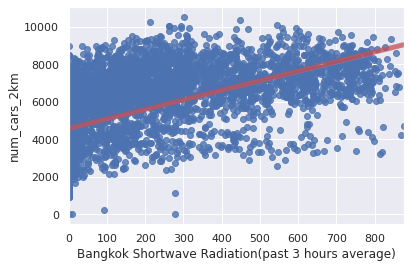

In [ ]:
ax = sns.regplot(x=data.loc[:,'Bangkok Shortwave Radiation(past 3 hours average)'], y=data.loc[:, 'num_cars_2km'], line_kws={"color":"r","alpha":0.7,"lw":5})

In [ ]:
ax = sns.regplot(x=X.loc[:,'aqi(past 8 hours average)'], y=data.loc[:, 'aqi'], line_kws={"color":"r","alpha":0.7,"lw":5})

In [ ]:
ax = sns.regplot(x=X.loc[:,'aqi(past 24 hours average)'], y=data.loc[:, 'aqi'], line_kws={"color":"r","alpha":0.7,"lw":5})

In [ ]:
ax = sns.regplot(x=X.loc[:,'Bangkok Diffuse Shortwave Radiation(past 3 hours average)'], y=data.loc[:, 'aqi'], line_kws={"color":"r","alpha":0.7,"lw":5})

In [ ]:
ax = sns.regplot(x=X.loc[:,'Bangkok Geopotential Height [850 mb]'], y=data.loc[:, 'aqi'], line_kws={"color":"r","alpha":0.7,"lw":5})

In [ ]:
ax = sns.regplot(x=X.loc[:,'Bangkok Direct Shortwave Radiation(past 3 hours average)'], y=data.loc[:, 'aqi'], line_kws={"color":"r","alpha":0.7,"lw":5})

In [ ]:
ax = sns.regplot(x=X.loc[:,'num_cars_2km'], y=data.loc[:, 'aqi'], line_kws={"color":"r","alpha":0.7,"lw":5})

In [ ]:
 ax = sns.regplot(x=X.loc[:,'Avg_speed_5km'], y=data.loc[:, 'aqi'], line_kws={"color":"r","alpha":0.7,"lw":5})

In [ ]:
 ax = sns.regplot(x=X.loc[:,'Bangkok Evapotranspiration(past 3 hours average)'], y=data.loc[:, 'aqi'], line_kws={"color":"r","alpha":0.7,"lw":5})

In [ ]:
# file_path_merge_May_Sep_5km = '/content/drive/My Drive/air_polution/merge_May_Sep_5km.csv'
# data = pd.read_csv(file_path_merge_May_Sep_5km)
# X = data.drop(columns={'timestamp','station','Latitude','Longitude', 'pm25','pm10','o3','no2','so2','co','aqi','index_x', 'index_y', 'index', 'Bangkok Snowfall Amount'
# , 'Bangkok Cloud Cover High [high cld lay]', 'Bangkok Cloud Cover Medium [mid cld lay]',	'Bangkok Cloud Cover Low [low cld lay]'}) 
# 'Bangkok Temperature [2 m elevation corrected]', 
# 'Bangkok Relative Humidity [2 m]', 'Bangkok Mean Sea Level Pressure [MSL]', 'Bangkok Precipitation Total', 'Bangkok Cloud Cover Total', 'Bangkok Sunshine Duration', 
# 'Bangkok Shortwave Radiation', 'Bangkok Direct Shortwave Radiation', 'Bangkok Diffuse Shortwave Radiation', 'Bangkok Evapotranspiration', 'Bangkok FAO Reference Evapotranspiration [2 m]', 
# 'Bangkok CAPE [180-0 mb above gnd]', 'Bangkok Wind Gust', 'Bangkok Wind Speed [10 m]', 'Bangkok Wind Direction [10 m]', 'Bangkok Wind Speed [80 m]', 'Bangkok Wind Direction [80 m]', 
# 'Bangkok Wind Direction [900 mb]', 'Bangkok Wind Speed [500 mb]', 'Bangkok Geopotential Height [1000 mb]', 'Bangkok Geopotential Height [700 mb]', 'Bangkok Geopotential Height [500 mb]', 
# 'Bangkok Temperature [1000 mb]', 'Bangkok Temperature [700 mb]', 'Bangkok Soil Temperature [0-10 cm down]', 'Bangkok Vapor Pressure Deficit [2 m]', 'electricity', 'wind_speed'})
# Y = data.loc[:, 'aqi'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
# out_path = '/content/drive/My Drive/air_polution/X_5km.csv'
# X.to_csv(out_path, index = True)

scaler = StandardScaler().fit(X)
X = scaler.fit_transform(X)
# Y = np.log(Y)
# Y = np.ravel(Y)
# split the train set into training data and validation data
# X_train, X_val, y_train, y_val = train_test_split(
#     X, Y, train_size=0.75
# )
# y_train = np.ravel(y_train)
# y_val = np.ravel(y_val)

# Feature selection

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.decomposition import KernelPCA
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit
import xgboost as xgb

In [ ]:
# determine which feature selection select the best set of parameters with best accuracy
estimator = GradientBoostingRegressor(max_depth=8)
clf = Pipeline([
  ('feature_selection', RFE(estimator, n_features_to_select=150, step=0.05)),
  ('regression', GradientBoostingRegressor(max_depth=8))
])

In [ ]:
# k fold split
feature_selection = cross_validate(clf, X, Y, cv=10, scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (feature_selection['test_score'].mean(), feature_selection['test_score'].std() * 2))
clf['feature_selection'].n_features_
clf['feature_selection'].ranking_

Accuracy: 0.80 (+/- 0.13)


AttributeError: ignored

In [ ]:
a = selector.ranking_
idx = [a[i] for i in np.where(a == 1)]
print(idx)
print(np.where(a == 1))

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
(array([  0,   1,   2,   3,   4,   5,  12,  13,  14,  15,  16,  17,  19,
        20,  21,  23,  24,  25,  26,  27,  30,  32,  35,  36,  37,  38,
        39,  40,  41,  42,  44,  45,  46,  47,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  62,  63,  66,  67,  68,  70,  71,
        74,  75,  76,  77,  78,  79,  83,  87,  98, 103, 106, 107, 110,
       111, 113, 114, 116, 117, 118, 119, 122, 123, 124, 127, 130, 131,
       133, 134, 135, 136, 137, 142, 147, 149, 150, 157, 162, 163, 165,
       166, 167, 171, 175, 178, 179, 186, 187, 194, 198, 202

In [ ]:
# time series split
tscv = TimeSeriesSplit(n_splits=10)
scores = []
for train_index, test_index in tscv.split(X):
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     clf.fit(X_train, y_train)
     scores.append(clf.score(X_test, y_test))
print(scores.mean())

In [ ]:
# dimension reduction
# PCA
transformer = KernelPCA(n_components=7, kernel='rbf')
X_transformed = transformer.fit_transform(X)

In [ ]:
# wrapper
# RFECV
xgb_model = xgb.XGBRegressor(max_depth=3, objective= 'reg:squarederror', booster= 'gbtree', n_estimators=300, learning_rate= 0.1, subsample= 0.9, min_child_weight= 10, colsample_bytree= 0.8)
selector = RFECV(xgb_model, step=0.05, cv=ShuffleSplit(n_splits=10, test_size=0.1, random_state=1), min_features_to_select = 50)
selector = selector.fit(X, Y)

In [ ]:
selector.n_features_
a = selector.ranking_
# selector.grid_scores_.std()
# Reduce X to the selected features.
X = selector.transform(X)

In [ ]:
index = np.where(a == 1)
print(index)

(array([  1,   2,   3,   4,   5,   7,  13,  14,  17,  26,  35,  36,  51,
        55,  58,  59,  63,  66,  70,  71,  74,  75,  76,  83,  98,  99,
       102, 106, 110, 111, 114, 119, 126, 127, 128, 130, 131, 135, 162,
       171, 186, 187, 194, 195, 198, 202, 204, 205, 246, 251, 254, 255]),)


In [ ]:
# traffic data cleaning
y_list = [Y1, Y2, Y3, Y4, Y5, Y6]
for y in y_list:
  y = np.ravel(y)
  xgb_model = xgb.XGBRegressor(max_depth=3, objective= 'reg:squarederror', booster= 'gbtree', n_estimators=300, learning_rate= 0.1, subsample= 0.9, min_child_weight= 10, colsample_bytree= 0.8)
  selector = RFECV(xgb_model, step=0.05, cv=ShuffleSplit(n_splits=10, test_size=0.1, random_state=1), min_features_to_select = 50)
  selector = selector.fit(X, y)
  a = selector.ranking_
  index = np.where(a == 1)
  print(index)

(array([  0,   7,   9,  10,  11,  13,  21,  26,  31,  35,  39,  45,  46,
        47,  48,  49,  50,  51,  53,  54,  55,  56,  57,  58,  61,  62,
        63,  64,  65,  66,  72,  97,  98, 105, 106, 109, 110, 114, 143,
       144, 147, 158, 167, 174, 185, 242, 249, 250, 251, 253]),)
(array([  0,  11,  17,  18,  22,  23,  45,  46,  47,  49,  50,  51,  52,
        53,  54,  57,  58,  61,  63,  65,  66,  67,  68,  69,  71,  72,
        73,  75,  93,  97,  98, 101, 102, 105, 106, 110, 113, 114, 135,
       157, 165, 173, 174, 175, 182, 188, 211, 249, 250, 251, 253]),)
(array([  1,   7,   9,  10,  11,  13,  15,  22,  23,  26,  31,  39,  45,
        46,  47,  48,  49,  50,  52,  53,  54,  55,  56,  57,  58,  61,
        62,  63,  64,  65,  66,  71,  72,  81,  94,  97,  98, 101, 105,
       106, 114, 129, 148, 157, 159, 163, 166, 173, 174, 175, 182, 185,
       193, 206, 211, 235, 241, 242, 246, 249, 250, 251, 253]),)
(array([  0,   1,   7,   8,   9,  10,  11,  13,  15,  16,  18,  19,  22,
    

In [ ]:
X = selector.transform(X)

In [ ]:
features = []
for i in index:
  features.append(X.columns[i])
print(features) 

In [ ]:
out_path = '/content/drive/My Drive/air_polution/REFCV(boosting)_selected_features.txt'
savetxt(out_path, X, delimiter=',')

NameError: ignored

In [ ]:
X = loadtxt(out_path, delimiter=',')

In [ ]:
# filter
# incorporate with various estimetors
SelectFromModel(LinearSVC(penalty="l1"))
SelectFromModel(GradientBoostingClassifier())

# Model tuning

In [ ]:
# traditional method grid search and randomized search
# grid search
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv = 10)
clf.fit(iris.data, iris.target)
clf.cv_results_
# 	Call transform on the estimator with the best found parameters.
clf.transfrom(X)

In [ ]:
# randomized search
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=14b0f561d500e028930d87b71f08af166aba4bc169a50277e615da8df94d626c
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
# genetic algorithm
xgb_model = xgb.XGBRegressor(max_depth=3, objective= 'reg:squarederror', booster= 'gbtree', n_estimators=300, learning_rate= 0.1, subsample= 0.9, min_child_weight= 10, colsample_bytree= 0.8)
selector = RFECV(xgb_model, step=0.05, cv=ShuffleSplit(n_splits=10, test_size=0.1, random_state=1), min_features_to_select = 50)
selector = selector.fit(X, Y)

SyntaxError: ignored

In [ ]:
def xgbcv(X, Y, NT, L, sub_sample, sample_bytree, maxDepth, min_childWeight):
  tscv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=1)
  RMSE = []
  testR = []
  for train_index, test_index in tscv.split(X):
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = Y[train_index], Y[test_index]
     dtrain = xgb.DMatrix(X_train, label=y_train)
     dtest = xgb.DMatrix(X_test)
     xgb_model = xgb.XGBRegressor(max_depth=maxDepth, objective= 'reg:squarederror', booster= 'gbtree', n_estimators=NT, learning_rate= L, subsample= sub_sample,
                                  min_child_weight= min_childWeight, colsample_bytree= sample_bytree)
     xgb_model.fit(X_train, y_train)
     y_pred = xgb_model.predict(X_test)
     testR.append(r2_score(y_test, y_pred))
     RMSE.append(mean_squared_error(y_test, y_pred))
  return np.mean(testR)

In [ ]:
# bayesian optimization (BO)
from bayes_opt import BayesianOptimization
def optimize_xgb (X, Y):
  def black_box_function (NT, L, sub_sample, sample_bytree, maxDepth, min_childWeight):
    return xgbcv(
        X = X, 
        Y = Y, 
        NT = int(NT), 
        L = float(L),
        sub_sample = float(sub_sample), 
        sample_bytree = float(sample_bytree), 
        maxDepth = int(maxDepth), 
        min_childWeight = int(min_childWeight))

  pbounds = {'NT': (0, 1000), 'L': (0, 0.3), 'sub_sample': (0, 1), 'sample_bytree': (0, 1), 'maxDepth': (0, 10), 'min_childWeight': (0 ,10)}

  optimizer = BayesianOptimization(
      f=black_box_function,
      pbounds=pbounds,
      random_state=1,
  )
  optimizer.maximize(n_iter=20, init_points = 5)

  print(optimizer.max)

optimize_xgb(X, Y)

|   iter    |  target   |     L     |    NT     | maxDepth  | min_ch... | sample... | sub_sa... |
-------------------------------------------------------------------------------------------------
|  1        | -0.004488 |  0.1251   |  720.3    |  0.001144 |  3.023    |  0.1468   |  0.09234  |
|  2        |  0.8959   |  0.05588  |  345.6    |  3.968    |  5.388    |  0.4192   |  0.6852   |
|  3        | -0.00389  |  0.06134  |  878.1    |  0.2739   |  6.705    |  0.4173   |  0.5587   |
|  4        |  0.8868   |  0.04212  |  198.1    |  8.007    |  9.683    |  0.3134   |  0.6923   |
|  5        | -0.00385  |  0.2629   |  894.6    |  0.8504   |  0.3905   |  0.1698   |  0.8781   |
|  6        | -9.126    |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |  0.0      |
|  7        |  0.8945   |  0.04953  |  269.1    |  6.537    |  8.161    |  0.3701   |  0.7133   |
|  8        | -9.126    |  0.0      |  419.2    |  10.0     |  10.0     |  0.0      |  0.3477   |
|  9        |  0.897

# Model

In [ ]:
# file_path_merge_May_Sep_5km = '/content/drive/My Drive/air_polution/merge_May_Sep_5km.csv'
# data = pd.read_csv(file_path_merge_May_Sep_5km)
# outliers = [(data['aqi'] > 250) and (data['aqi'] < 250)]
# data.drop(data[outliers] > 250].index, inplace = True) 
# X = data.drop(columns={'timestamp','station','Latitude','Longitude', 'pm25','pm10','o3','no2','so2','co','aqi','index_x', 'index_y', 'index', 'Bangkok Snowfall Amount'
# , 'Bangkok Cloud Cover High [high cld lay]', 'Bangkok Cloud Cover Medium [mid cld lay]',	'Bangkok Cloud Cover Low [low cld lay]'}) 
# # 'Bangkok Temperature [2 m elevation corrected]', 
# # 'Bangkok Relative Humidity [2 m]', 'Bangkok Mean Sea Level Pressure [MSL]', 'Bangkok Precipitation Total', 'Bangkok Cloud Cover Total', 'Bangkok Sunshine Duration', 
# # 'Bangkok Shortwave Radiation', 'Bangkok Direct Shortwave Radiation', 'Bangkok Diffuse Shortwave Radiation', 'Bangkok Evapotranspiration', 'Bangkok FAO Reference Evapotranspiration [2 m]', 
# # 'Bangkok CAPE [180-0 mb above gnd]', 'Bangkok Wind Gust', 'Bangkok Wind Speed [10 m]', 'Bangkok Wind Direction [10 m]', 'Bangkok Wind Speed [80 m]', 'Bangkok Wind Direction [80 m]', 
# # 'Bangkok Wind Direction [900 mb]', 'Bangkok Wind Speed [500 mb]', 'Bangkok Geopotential Height [1000 mb]', 'Bangkok Geopotential Height [700 mb]', 'Bangkok Geopotential Height [500 mb]', 
# # 'Bangkok Temperature [1000 mb]', 'Bangkok Temperature [700 mb]', 'Bangkok Soil Temperature [0-10 cm down]', 'Bangkok Vapor Pressure Deficit [2 m]', 'electricity', 'wind_speed'})
# Y = data.loc[:, 'aqi'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
# out_path = '/content/drive/My Drive/air_polution/X_5km.csv'
# X.to_csv(out_path, index = True)

# scaler = StandardScaler().fit(X)
# X = scaler.fit_transform(X)
# Y = np.log(Y)
# # split the train set into training data and validation data
# X_train, X_val, y_train, y_val = train_test_split(
#     X, Y, train_size=0.75
# )
# y_train = np.ravel(y_train)
# y_val = np.ravel(y_val)

## Lasso

In [ ]:
# lasso
lr = make_pipeline(PCA(n_components=5),
                   linear_model.Lasso(alpha=0.5, max_iter=10000))
lr.fit(X_train, y_train)
print(lr.score(X_val, y_val))

-0.005972487730008468


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


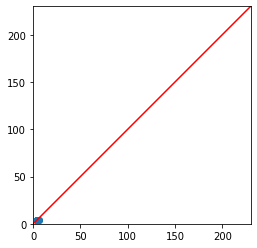

In [ ]:
plt.scatter(y_val, lr.predict(X_val))
plt.xlim(0, 230)
plt.ylim(0, 230)
plt.gca().set_aspect('equal', adjustable='box')
ax = plt.axes()
x = np.linspace(0, 230, 2000)
ax.plot(x, x, 'r');

## RF

In [ ]:
rf_model = RandomForestRegressor( )
rf_cv = cross_validate(rf_model, X, Y, cv=ShuffleSplit(n_splits=10, test_size=0.1, random_state=1), scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (rf_cv['test_score'].mean(), rf_cv['test_score'].std() * 2))

Accuracy: 0.88 (+/- 0.02)


In [ ]:
tscv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=1)
scores = []
train_scores = []
features_importance = []
RMSE = []
for train_index, test_index in tscv.split(X):
     Y1 = np.ravel(Y1)
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = Y1[train_index], Y1[test_index]
     rf_model = RandomForestRegressor( )
     rf_model.fit(X_train, y_train)
     y_pred = rf_model.predict(X_test)
     scores.append(r2_score(y_test, y_pred))
     train_scores.append(r2_score(y_train, rf_model.predict(X_train)))
     RMSE.append(mean_squared_error(y_test, y_pred))
     features_importance.append(rf_model.feature_importances_)
print("Accuracy of test r2: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))
print("Accuracy of train r2: %0.2f (+/- %0.2f)" % (np.mean(train_scores), np.std(train_scores) * 2))
print("Accuracy of RMSE: %0.2f (+/- %0.2f)" % (np.mean(RMSE), np.std(RMSE) * 2))

Accuracy of test r2: 0.97 (+/- 0.02)
Accuracy of train r2: 1.00 (+/- 0.00)
Accuracy of RMSE: 0.77 (+/- 0.47)


In [ ]:
tscv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=1)
scores = []
train_scores = []
features_importance = []
RMSE = []
y_list = [Y1, Y2, Y3, Y4, Y5, Y6]
for y in y_list:
  for train_index, test_index in tscv.split(X):
      y = np.ravel(y)
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      rf_model = RandomForestRegressor( )
      rf_model.fit(X_train, y_train)
      y_pred = rf_model.predict(X_test)
      scores.append(r2_score(y_test, y_pred))
      train_scores.append(r2_score(y_train, rf_model.predict(X_train)))
      RMSE.append(mean_squared_error(y_test, y_pred))
      features_importance.append(rf_model.feature_importances_)
  print("Accuracy of test r2: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))
  print("Accuracy of train r2: %0.2f (+/- %0.2f)" % (np.mean(train_scores), np.std(train_scores) * 2))
  print("Accuracy of RMSE: %0.2f (+/- %0.2f)" % (np.mean(RMSE), np.std(RMSE) * 2))

Accuracy of test r2: 0.97 (+/- 0.01)
Accuracy of train r2: 1.00 (+/- 0.00)
Accuracy of RMSE: 0.80 (+/- 0.45)
Accuracy of test r2: 0.97 (+/- 0.01)
Accuracy of train r2: 1.00 (+/- 0.00)
Accuracy of RMSE: 119370.90 (+/- 243142.14)
Accuracy of test r2: 0.97 (+/- 0.01)
Accuracy of train r2: 1.00 (+/- 0.00)
Accuracy of RMSE: 79580.80 (+/- 228206.23)
Accuracy of test r2: 0.98 (+/- 0.01)
Accuracy of train r2: 1.00 (+/- 0.00)
Accuracy of RMSE: 198592.16 (+/- 470238.18)
Accuracy of test r2: 0.97 (+/- 0.01)
Accuracy of train r2: 1.00 (+/- 0.00)
Accuracy of RMSE: 158873.85 (+/- 449599.68)
Accuracy of test r2: 0.98 (+/- 0.02)
Accuracy of train r2: 1.00 (+/- 0.00)
Accuracy of RMSE: 426463.15 (+/- 1352841.80)


In [ ]:
features_importance = np.array(features_importance)
feature_mean = features_importance.mean(axis = 0)
print(feature_mean)
value_rf = [feature_mean[i] for i in np.where(feature_mean > 0.00145)]
print(value_rf)
index_rf = np.where(feature_mean > 0.00145)
print(index_rf)
sorted_array = sorted(enumerate(feature_mean), key=lambda x:x[1], reverse = True)
print(sorted_array)

[6.49807773e-04 5.04931610e-03 1.17789291e-02 4.75331368e-04
 6.27464661e-04 5.31644468e-04 4.25574143e-04 5.40516803e-04
 5.02175979e-04 5.16771601e-04 6.07088922e-04 2.46231046e-01
 1.09728345e-03 1.12400283e-03 5.68658217e-04 8.40026326e-04
 5.12244334e-04 4.69049033e-04 6.10547796e-01 1.05732015e-03
 8.14007455e-04 5.33541039e-04 1.16797699e-03 7.39272145e-04
 1.55038422e-03 9.81695153e-04 8.81864144e-04 4.89782628e-04
 1.21120983e-03 7.60083145e-04 6.43565561e-04 1.26949420e-02
 6.58570765e-04 1.15713943e-02 5.79509850e-03 6.58591364e-04
 5.63978787e-04 5.94139926e-04 4.76533050e-04 3.93613674e-04
 6.21463468e-04 4.95191656e-04 5.61325375e-04 8.41081113e-04
 4.81639799e-04 5.60928624e-04 1.19755149e-02 3.85833191e-02
 1.48117301e-02 3.73551323e-03]
[array([0.00504932, 0.01177893, 0.24623105, 0.6105478 , 0.00155038,
       0.01269494, 0.01157139, 0.0057951 , 0.01197551, 0.03858332,
       0.01481173, 0.00373551])]
(array([ 1,  2, 11, 18, 24, 31, 33, 34, 46, 47, 48, 49]),)
[(18, 0.6

In [ ]:
rf_features = []
for i in importantFeature:
  rf_features.append(features[i])
print(rf_features) 

In [ ]:
rf_cv['test_score']

array([0.8312316 , 0.81280375, 0.79614767, 0.79981299, 0.60999171,
       0.83672879, 0.83313079, 0.8592664 , 0.85109498, 0.83036302])

## Boosting

In [ ]:
# treet boosing
boosting_model = GradientBoostingRegressor(max_depth=10)
clf = Pipeline([
  ('regression', GradientBoostingRegressor(max_depth=8))
])
boosting_cv = cross_validate(clf, X, Y, cv=ShuffleSplit(n_splits=10, test_size=0.1, random_state=1), scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (boosting_cv['test_score'].mean(), boosting_cv['test_score'].std() * 2))

Accuracy: 0.89 (+/- 0.02)


In [ ]:
tscv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=1)
scores = []
train_scores = []
features_importance = []
RMSE = []
for train_index, test_index in tscv.split(X):
     Y6 = np.ravel(Y6)
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = Y6[train_index], Y6[test_index]
     rf_model = GradientBoostingRegressor(max_depth=4, n_estimators=200)
     rf_model.fit(X_train, y_train)
     y_pred = rf_model.predict(X_test)
     scores.append(r2_score(y_test, y_pred))
     train_scores.append(r2_score(y_train, rf_model.predict(X_train)))
     RMSE.append(mean_squared_error(y_test, y_pred))
     features_importance.append(rf_model.feature_importances_)
print("Accuracy of test r2: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))
print("Accuracy of train r2: %0.2f (+/- %0.2f)" % (np.mean(train_scores), np.std(train_scores) * 2))
print("Accuracy of RMSE: %0.2f (+/- %0.2f)" % (np.mean(RMSE), np.std(RMSE) * 2))

In [ ]:
features_importance = np.array(features_importance)
feature_mean = features_importance.mean(axis = 0)
print(feature_mean)
value_rf = [feature_mean[i] for i in np.where(feature_mean > 0.00145)]
print(value_rf)
index_rf = np.where(feature_mean > 0.00145)
print(index_rf)
sorted_array = sorted(enumerate(feature_mean), key=lambda x:x[1], reverse = True)
print(sorted_array)

[6.99532445e-04 2.94442261e-03 1.42682837e-04 3.32185198e-05
 3.60424309e-05 7.06408442e-05 6.39005220e-05 3.84015098e-05
 8.02513619e-04 1.45207383e-03 4.28846289e-04 4.17612644e-04
 3.27453803e-04 2.41611696e-05 1.25704564e-04 9.15773752e-05
 1.32432874e-04 5.27107552e-04 3.58531334e-04 5.85916785e-05
 1.33147065e-04 1.34498159e-04 9.67966138e-01 5.47975202e-04
 1.79133826e-04 1.50567262e-04 3.57737415e-05 6.25219299e-05
 3.20952765e-05 2.14964663e-03 2.42191488e-04 1.97863094e-04
 4.59574153e-04 3.15547202e-05 3.66931755e-05 5.10852080e-05
 3.31538617e-05 4.38158692e-05 2.43292901e-05 2.60640127e-05
 3.06045912e-05 6.42152919e-05 5.02365557e-05 4.40087791e-05
 5.13877525e-05 4.07003171e-05 3.53719687e-03 1.15706019e-02
 2.90241354e-03 3.95364246e-04]
[array([0.00294442, 0.00145207, 0.96796614, 0.00214965, 0.0035372 ,
       0.0115706 , 0.00290241])]
(array([ 1,  9, 22, 29, 46, 47, 48]),)
[(22, 0.9679661377138629), (47, 0.011570601929582534), (46, 0.003537196870299914), (1, 0.0029444

In [ ]:
boosting_model = GradientBoostingRegressor(max_depth=10)
boosting_cv_time = cross_validate(boosting_model, X, Y, cv=TimeSeriesSplit(n_splits=10), scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (boosting_cv_time['test_score'].mean(), boosting_cv_time['test_score'].std() * 2))

Accuracy: 0.72 (+/- 0.21)


In [ ]:
b = boosting_cv['regression'].feature_importances_
idx = [a[i] for i in np.where(a > 0.03)]
print(idx)

NotFittedError: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


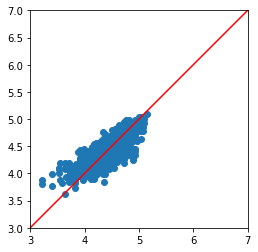

In [ ]:
plt.scatter(y_val, boosting_model.predict(X_val))
plt.xlim(3, 7)
plt.ylim(3, 7)
plt.gca().set_aspect('equal', adjustable='box')
ax = plt.axes()
x = np.linspace(0, 230, 2000)
ax.plot(x, x, 'r');

## XGboost (extreme gradient boosting tree)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import KFold
tscv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=1)
scores = []
for train_index, test_index in tscv.split(X):
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = Y[train_index], Y[test_index]
     dtrain = xgb.DMatrix(X_train, label=y_train)
     dtest = xgb.DMatrix(X_test)
     param = {'max_depth': 8, 'eta': 0.5}
     bst = xgb.train(params = param, dtrain = dtrain, num_boost_round=10)
     y_pred = bst.predict(dtest)
     scores.append(r2_score(y_test, y_pred))
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))


NameError: ignored

In [ ]:
def plotResult(y_val, y_pred):
  plt.scatter(y_val, y_pred)
  plt.plot

0.9680062585555482
4777443.408788635
0.9585371517417242
6731444.490206845
0.9589488354099205
8519478.961022068
0.9832653069894459
2586876.620457561
0.9737739851536529
4080761.0815822324
0.9878668934938315
1641299.292354177
0.9744928184223075
3363201.6767097283
0.9747388127056476
3150646.044489635
Accuracy of test r2: 0.97 (+/- 0.02)
Accuracy of train r2: 1.00 (+/- 0.00)
Accuracy of RMSE: 4356393.95 (+/- 4252563.20)


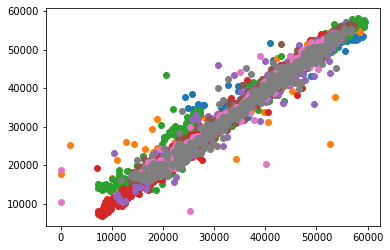

In [ ]:
import xgboost as xgb
tscv = TimeSeriesSplit(n_splits=8)
scores = []
train_scores = []
features_importance = []
RMSE = []
for train_index, test_index in tscv.split(X):
     Y6 = np.ravel(Y6)
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = Y6[train_index], Y6[test_index]
     dtrain = xgb.DMatrix(X_train, label=y_train)
     dtest = xgb.DMatrix(X_test)
     xgb_model = xgb.XGBRegressor(max_depth=7, objective= 'reg:squarederror', booster= 'gbtree', n_estimators=270, learning_rate= 0.075, subsample= 0.8, min_child_weight= 8, colsample_bytree= 0.825)
     xgb_model.fit(X_train, y_train)
     y_pred = xgb_model.predict(X_test)
     plotResult(y_test, y_pred)
     scores.append(r2_score(y_test, y_pred))
     print(r2_score(y_test, y_pred))
     train_scores.append(r2_score(y_train, xgb_model.predict(X_train)))
     RMSE.append(mean_squared_error(y_test, y_pred))
     print(mean_squared_error(y_test, y_pred))
     features_importance.append(xgb_model.feature_importances_)
print("Accuracy of test r2: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))
print("Accuracy of train r2: %0.2f (+/- %0.2f)" % (np.mean(train_scores), np.std(train_scores) * 2))
print("Accuracy of RMSE: %0.2f (+/- %0.2f)" % (np.mean(RMSE), np.std(RMSE) * 2))

In [ ]:
features_importance = np.array(features_importance)
feature_mean = features_importance.mean(axis = 0)
print(feature_mean)
value_rf = [feature_mean[i] for i in np.where(feature_mean > 0.00145)]
print(value_rf)
index_rf = np.where(feature_mean > 0.00145)
print(index_rf)
sorted_array = sorted(enumerate(feature_mean), key=lambda x:x[1], reverse = True)
print(sorted_array)

[3.1944562e-04 6.0610491e-04 3.5614666e-04 3.4593127e-04 3.4593770e-04
 2.4676605e-04 6.6073058e-04 2.6805295e-02 3.8747680e-03 2.3544429e-02
 2.2876391e-03 2.2619648e-02 3.5272131e-04 2.5919391e-04 3.2672303e-04
 2.9905056e-04 2.4167301e-04 2.5446375e-04 5.1413226e-04 2.0367847e-04
 2.2440102e-04 4.1144027e-04 3.4795571e-04 2.8896297e-04 7.5568474e-04
 3.1685288e-04 3.7216896e-04 5.4471521e-04 2.9751234e-04 4.3743238e-04
 3.6429893e-04 3.8188760e-04 2.2277806e-04 2.2765406e-04 2.4696728e-04
 4.1839940e-04 2.1718020e-04 1.9300298e-04 2.3061701e-04 2.9378448e-04
 2.1231738e-04 2.5948350e-04 2.6894218e-04 4.4196518e-04 2.9947789e-04
 1.7790943e-03 2.5000924e-02 1.7360407e-03 5.5969291e-04 5.3117022e-02
 4.1933767e-03 4.9436036e-03 4.9780845e-04 4.1467706e-03 7.0536779e-03
 9.3487534e-04 5.1832490e-04 1.3342334e-01 6.5415390e-03 1.9239921e-03
 5.4373423e-04 2.3510629e-02 5.8698904e-04 2.2201021e-03 4.4391677e-04
 3.4802300e-01 7.8014717e-03 1.3631170e-03 4.8416940e-04 1.7710209e-04
 2.557

## knn regression

In [ ]:
# knn regression
knn = neighbors.KNeighborsRegressor(2)
knn_cv = cross_validate(knn, X, Y, cv=ShuffleSplit(n_splits=10, test_size=0.1, random_state=1), scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (knn_cv['test_score'].mean(), knn_cv['test_score'].std() * 2))

Accuracy: 0.84 (+/- 0.03)


In [ ]:
tscv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=1)
scores = []
train_scores = []
features_importance = []
RMSE = []
for train_index, test_index in tscv.split(X):
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = Y[train_index], Y[test_index]
     knn_model = neighbors.KNeighborsRegressor(2)
     knn_model.fit(X_train, y_train)
     y_pred = knn_model.predict(X_test)
     scores.append(r2_score(y_test, y_pred))
     train_scores.append(r2_score(y_train, knn_model.predict(X_train)))
     RMSE.append(mean_squared_error(y_test, y_pred))
print("Accuracy of test r2: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))
print("Accuracy of train r2: %0.2f (+/- %0.2f)" % (np.mean(train_scores), np.std(train_scores) * 2))
print("Accuracy of RMSE: %0.2f (+/- %0.2f)" % (np.mean(RMSE), np.std(RMSE) * 2))

Accuracy of test r2: 0.83 (+/- 0.03)
Accuracy of train r2: 0.94 (+/- 0.00)
Accuracy of RMSE: 152.28 (+/- 22.76)


In [ ]:
knn_cv['test_score']

array([-0.38390945, -0.00849499, -0.23657244, -0.21057404, -0.26483155,
        0.13391867,  0.17037083, -0.08668692, -0.4680151 , -0.8249952 ])

## svm regression

In [ ]:
# svm regression
svr = SVR(C=10)
svr_cv = cross_validate(svr, X, Y, cv=ShuffleSplit(n_splits=10, test_size=0.1, random_state=1), scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (svr_cv['test_score'].mean(), svr_cv['test_score'].std() * 2))

Accuracy: 0.87 (+/- 0.02)


In [ ]:
tscv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=1)
scores = []
train_scores = []
features_importance = []
RMSE = []
for train_index, test_index in tscv.split(X):
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = Y[train_index], Y[test_index]
     svr_model = SVR(C=20)
     svr_model.fit(X_train, y_train)
     y_pred = svr_model.predict(X_test)
     scores.append(r2_score(y_test, y_pred))
     train_scores.append(r2_score(y_train, svr_model.predict(X_train)))
     RMSE.append(mean_squared_error(y_test, y_pred))
     features_importance.append(svr_model.dual_coef_)
print("Accuracy of test r2: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))
print("Accuracy of train r2: %0.2f (+/- %0.2f)" % (np.mean(train_scores), np.std(train_scores) * 2))
print("Accuracy of RMSE: %0.2f (+/- %0.2f)" % (np.mean(RMSE), np.std(RMSE) * 2))

Accuracy of test r2: 0.89 (+/- 0.02)
Accuracy of train r2: 0.92 (+/- 0.00)
Accuracy of RMSE: 98.02 (+/- 13.83)


In [ ]:

feature_mean = features_importance.mean(axis = 0)
print(feature_mean)
value_rf = [feature_mean[i] for i in np.where(feature_mean > 0.00145)]
print(value_rf)
index_rf = np.where(feature_mean > 0.00145)
print(index_rf)
sorted_array = sorted(enumerate(feature_mean), key=lambda x:x[1], reverse = True)
print(sorted_array)

AttributeError: ignored

In [ ]:
svr.dual_coef_

array([[ 6.22353262, -0.40050309, -0.21649348, ..., 13.96313361,
        -0.13578592,  0.07948564]])

## Neural network

In [ ]:
# neural network
DNN = MLPRegressor(hidden_layer_sizes=(50,50,50,30,30,30,30,10), activation='tanh', early_stopping=True, batch_size=50, max_iter=1000, verbose=False)
DNN_cv = cross_validate(DNN, X, Y, cv=ShuffleSplit(n_splits=10, test_size=0.1, random_state=1), scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (DNN_cv['test_score'].mean(), DNN_cv['test_score'].std() * 2))

Accuracy: 0.25 (+/- 0.79)


In [ ]:
tscv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=1)
scores = []
train_scores = []
features_importance = []
RMSE = []
for train_index, test_index in tscv.split(X):
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = Y[train_index], Y[test_index]
     MLP_model = MLPRegressor(hidden_layer_sizes=(128,64,64,64,32,32,32,32,16,16), activation='relu', early_stopping=True, batch_size=400, max_iter=1000, verbose=False)
     MLP_model.fit(X_train, y_train)
     y_pred = MLP_model.predict(X_test)
     scores.append(r2_score(y_test, y_pred))
     train_scores.append(r2_score(y_train, MLP_model.predict(X_train)))
     RMSE.append(mean_squared_error(y_test, y_pred))
print("Accuracy of test r2: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))
print("Accuracy of train r2: %0.2f (+/- %0.2f)" % (np.mean(train_scores), np.std(train_scores) * 2))
print("Accuracy of RMSE: %0.2f (+/- %0.2f)" % (np.mean(RMSE), np.std(RMSE) * 2))

Accuracy of test r2: 0.89 (+/- 0.02)
Accuracy of train r2: 0.92 (+/- 0.01)
Accuracy of RMSE: 100.44 (+/- 17.13)


In [ ]:
plt.scatter(y_val, y_pred)
plt.xlim(3, 7)
plt.ylim(3, 7)
plt.gca().set_aspect('equal', adjustable='box')
ax = plt.axes()
x = np.linspace(0, 230, 2000)
ax.plot(x, x, 'r');

NameError: ignored

In [ ]:
# Regression Example With Boston Dataset: Standardized and Larger
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# load dataset

# define the model
def larger_model():
	# create model
	model = Sequential()
	model.add(Dense(13, input_dim=40, kernel_initializer='normal', activation='relu'))
	model.add(Dense(6, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model
# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Larger: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Larger: -0.19 (0.11) MSE


dict_keys(['val_loss', 'loss'])


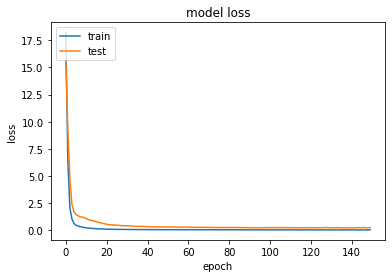

In [ ]:
model = larger_model()
history = model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred  = model.predict(X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


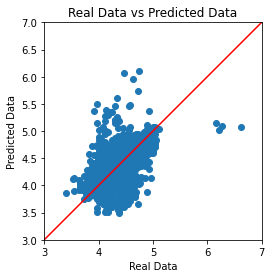

In [ ]:
plt.scatter(Y, y_pred)
plt.title('Real Data vs Predicted Data')
plt.xlabel('Real Data')
plt.ylabel('Predicted Data')
plt.xlim(3, 7)
plt.ylim(3, 7)
plt.gca().set_aspect('equal', adjustable='box')
ax = plt.axes()
x = np.linspace(0, 230, 2000)
ax.plot(x, x, 'r');
plt.show()

# Long-term prediction

**Direct prediction stategy**

In [ ]:
# estimate H direct models between the regressor y_t+h = f(y_t)

## MIMO

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
# dataset
file_path_merge_May_Sep_5km =  '/content/drive/My Drive/air_polution/merge_May_Dec_all_historic_aqiTime_deleteCopied.csv'
data = pd.read_csv(file_path_merge_May_Sep_5km)
data

,timestamp,Avg_speed_2km,num_cars_2km,Avg_speed_5km,num_cars_5km,Avg_speed_10km,num_cars_10km,aqi,Bangkok Temperature [2 m elevation corrected],Bangkok Relative Humidity [2 m],Bangkok Mean Sea Level Pressure [MSL],Bangkok Precipitation Total,Bangkok Cloud Cover Total,Bangkok Sunshine Duration,Bangkok Shortwave Radiation,Bangkok Direct Shortwave Radiation,Bangkok Diffuse Shortwave Radiation,Bangkok Evapotranspiration,Bangkok FAO Reference Evapotranspiration [2 m],Bangkok CAPE [180-0 mb above gnd],Bangkok Wind Gust,Bangkok Wind Speed [10 m],Bangkok Wind Speed [80 m],Bangkok Wind Speed [900 mb],Bangkok Wind Speed [850 mb],Bangkok Wind Speed [700 mb],Bangkok Wind Speed [500 mb],Bangkok Geopotential Height [1000 mb],Bangkok Geopotential Height [850 mb],Bangkok Geopotential Height [700 mb],Bangkok Geopotential Height [500 mb],Bangkok Temperature [1000 mb],Bangkok Temperature [850 mb],Bangkok Temperature [700 mb],Bangkok Temperature,Bangkok Soil Temperature [0-10 cm down],Bangkok Soil Moisture [0-10 cm down],Bangkok Vapor Pressure Deficit [2 m],Bangkok Wind Direction [10 m](sin),Bangkok Wind Direction [10 m](cos),...,Bangkok Wind Direction [900 mb](cos)(past 24 hours average),Bangkok Wind Direction [900 mb](cos)(past 48 hours average),Bangkok Wind Direction [850 mb](sin)(past 3 hours average),Bangkok Wind Direction [850 mb](sin)(past 8 hours average),Bangkok Wind Direction [850 mb](sin)(past 24 hours average),Bangkok Wind Direction [850 mb](sin)(past 48 hours average),Bangkok Wind Direction [850 mb](cos)(past 3 hours average),Bangkok Wind Direction [850 mb](cos)(past 8 hours average),Bangkok Wind Direction [850 mb](cos)(past 24 hours average),Bangkok Wind Direction [850 mb](cos)(past 48 hours average),Bangkok Wind Direction [700 mb](sin)(past 3 hours average),Bangkok Wind Direction [700 mb](sin)(past 8 hours average),Bangkok Wind Direction [700 mb](sin)(past 24 hours average),Bangkok Wind Direction [700 mb](sin)(past 48 hours average),Bangkok Wind Direction [700 mb](cos)(past 3 hours average),Bangkok Wind Direction [700 mb](cos)(past 8 hours average),Bangkok Wind Direction [700 mb](cos)(past 24 hours average),Bangkok Wind Direction [700 mb](cos)(past 48 hours average),Bangkok Wind Direction [500 mb](sin)(past 3 hours average),Bangkok Wind Direction [500 mb](sin)(past 8 hours average),Bangkok Wind Direction [500 mb](sin)(past 24 hours average),Bangkok Wind Direction [500 mb](sin)(past 48 hours average),Bangkok Wind Direction [500 mb](cos)(past 3 hours average),Bangkok Wind Direction [500 mb](cos)(past 8 hours average),Bangkok Wind Direction [500 mb](cos)(past 24 hours average),Bangkok Wind Direction [500 mb](cos)(past 48 hours average),electricity(past 3 hours average),electricity(past 8 hours average),electricity(past 24 hours average),electricity(past 48 hours average),wind_speed(past 3 hours average),wind_speed(past 8 hours average),wind_speed(past 24 hours average),wind_speed(past 48 hours average),hour of the day (sin),hour of the day (cos),month (sin),month (cos),"type of day (0 = workday, 1 = weekend, 2 = national holiday)",aqi(past 168 hours average)
0,2019-05-01 00:00:00,23.258523,4576,20.605752,13352,24.299181,31506,76.0,29.185314,75.0,1008.3,0.0,100.0,0.000000,0.0,0.0,0.0,0.00000,0.036527,2049.0,13.679999,9.327805,18.844202,16.981165,15.530151,6.924738,12.768586,73.0,1505.0,3160.0,5881.0,29.02,21.37,11.34,28.99,32.570007,0.166,10.164595,2.855983e-02,-9.995921e-01,...,-0.529999,-0.529999,-0.718602,-0.718602,-0.718602,-0.718602,-0.695421,-0.695421,-0.695421,-0.695421,0.155963,0.155963,0.155963,0.155963,-0.987763,-0.987763,-0.987763,-0.987763,0.648466,0.648466,0.648466,0.648466,0.761243,0.761243,0.761243,0.761243,0.014000,0.014000,0.014000,0.014000,2.857000,2.857000,2.857000,2.857000,0.000000,1.000000,5.000000e-01,-0.866025,2.0,76.000000
1,2019-05-01 01:00:00,23.953872,4119,23.194452,11535,26.241387,27748,61.0,29.065313,76.0,1008.1,0.0,100.0,0.000000,0.0,0.0,0.0,0.00144,0.034661,1991.0,13.679999,9.327805,19.245697,18.089775,15

In [ ]:
def future_h_y(Y, h, data):
  result = np.empty([0, h], dtype= int)
  for i in range(data.shape[0] - h):
    i = i+1
    temp = data.loc[i:i+h-1,str(Y)]
    result = np.vstack((result, temp))
  return result

In [ ]:
def incoporateHisForLongTerm(df, h, col):
  for i in range(df.shape[0]):
    if i < 24:
      continue
    else:
      for j in range(h):
        df.loc[i, str(col) +' (t-' + str(j+1) +')'] = df.loc[i-j-1, str(col)]
  return df

In [ ]:
data = incoporateHisForLongTerm(data, 24, 'aqi')

In [ ]:
data

,timestamp,Avg_speed_2km,num_cars_2km,Avg_speed_5km,num_cars_5km,Avg_speed_10km,num_cars_10km,aqi,Bangkok Temperature [2 m elevation corrected],Bangkok Relative Humidity [2 m],Bangkok Mean Sea Level Pressure [MSL],Bangkok Precipitation Total,Bangkok Cloud Cover Total,Bangkok Sunshine Duration,Bangkok Shortwave Radiation,Bangkok Direct Shortwave Radiation,Bangkok Diffuse Shortwave Radiation,Bangkok Evapotranspiration,Bangkok FAO Reference Evapotranspiration [2 m],Bangkok CAPE [180-0 mb above gnd],Bangkok Wind Gust,Bangkok Wind Speed [10 m],Bangkok Wind Speed [80 m],Bangkok Wind Speed [900 mb],Bangkok Wind Speed [850 mb],Bangkok Wind Speed [700 mb],Bangkok Wind Speed [500 mb],Bangkok Geopotential Height [1000 mb],Bangkok Geopotential Height [850 mb],Bangkok Geopotential Height [700 mb],Bangkok Geopotential Height [500 mb],Bangkok Temperature [1000 mb],Bangkok Temperature [850 mb],Bangkok Temperature [700 mb],Bangkok Temperature,Bangkok Soil Temperature [0-10 cm down],Bangkok Soil Moisture [0-10 cm down],Bangkok Vapor Pressure Deficit [2 m],Bangkok Wind Direction [10 m](sin),Bangkok Wind Direction [10 m](cos),...,Bangkok Wind Direction [500 mb](cos)(past 24 hours average),Bangkok Wind Direction [500 mb](cos)(past 48 hours average),electricity(past 3 hours average),electricity(past 8 hours average),electricity(past 24 hours average),electricity(past 48 hours average),wind_speed(past 3 hours average),wind_speed(past 8 hours average),wind_speed(past 24 hours average),wind_speed(past 48 hours average),hour of the day (sin),hour of the day (cos),month (sin),month (cos),"type of day (0 = workday, 1 = weekend, 2 = national holiday)",aqi(past 168 hours average),aqi (t-1),aqi (t-2),aqi (t-3),aqi (t-4),aqi (t-5),aqi (t-6),aqi (t-7),aqi (t-8),aqi (t-9),aqi (t-10),aqi (t-11),aqi (t-12),aqi (t-13),aqi (t-14),aqi (t-15),aqi (t-16),aqi (t-17),aqi (t-18),aqi (t-19),aqi (t-20),aqi (t-21),aqi (t-22),aqi (t-23),aqi (t-24)
0,2019-05-01 00:00:00,23.258523,4576,20.605752,13352,24.299181,31506,76.0,29.185314,75.0,1008.3,0.0,100.0,0.000000,0.0,0.0,0.0,0.00000,0.036527,2049.0,13.679999,9.327805,18.844202,16.981165,15.530151,6.924738,12.768586,73.0,1505.0,3160.0,5881.0,29.02,21.37,11.34,28.99,32.570007,0.166,10.164595,2.855983e-02,-9.995921e-01,...,0.761243,0.761243,0.014000,0.014000,0.014000,0.014000,2.857000,2.857000,2.857000,2.857000,0.000000,1.000000,5.000000e-01,-0.866025,2.0,76.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-05-01 01:00:00,23.953872,4119,23.194452,11535,26.241387,27748,61.0,29.065313,76.0,1008.1,0.0,100.0,0.000000,0.0,0.0,0.0,0.00144,0.034661,1991.0,13.679999,9.327805,19.245697,18.089775,15.913465,6.849467,11.090103,72.0,1502.0,3155.0,5875.0,28.90,20.85,11.00,28.80,32.119995,0.166,9.690628,2.855983e-02,-9.995921e-01,...,0.761243,0.761243,0.014000,0.014000,0.014000,0.014000,2.857000,2.857000,2.857000,2.857000,0.258819,0.965926,5.000000e-01,-0.866025,2.0,76.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-05-01 02:00:00,25.060471,3357,24.081961,9895,26.739299,23736,63.0,28.715315,77.0,1008.2,0.0,27.0,0.000000,0.0,0.0,0.0,0.00000,0.032476,1876.0,14.040000,9.324000,19.201874,18.847641,16.434305,6.130579,10.041354,72.0,1501.0,3151.0,5870.0,28.75,20.23,10.56,28.18,31.690002,0.166,9.100706,1.224647e-16,-1.000000e+00,...,0.672774,0.672774,0.010000,0.010000,0.010000,0.010000,2.666000,2.666000,2.666000,2.666000,0.500000,0.866025,5.000000e-01,-0.866025,2.0,68.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-05-01 03:00:00,27.225277,2983,26.190077,8102,27.834251,21062,55.0,28.075314,79.0,1008.3,0.0,10.0,0.000000,0.0,0.0,0.0,0.00000,0.028302,1703.0,13.320000,9.327805,20.172853,20.124610,17.317460,4.104631,10.495713,73.0,1501.0,3147.0,5865.0,28.69,19.58,10.08,27.59,31.250000,0.166,8.006205,-2.855983e-02,-9.995921e-01,...,0.532170,0.532170,0.007667,0.007667,0.007667,

In [ ]:
Y = future_h_y('aqi', 24, data)
Y.shape

(5610, 24)

In [ ]:
# do number of car in 2 km first
X = data.drop(columns={'timestamp','aqi'})
X = X.loc[24:Y.shape[0]-1,:]
scaler = StandardScaler().fit(X)
X = scaler.fit_transform(X)

In [ ]:
X

array([[-0.49487253, -0.49117226,  1.02469945, ..., -1.02159211,
        -0.64600678, -0.4207145 ],
       [-0.57433174, -0.6149565 ,  1.20350918, ..., -1.20593409,
        -1.02159109, -0.64596394],
       [-0.69701073, -0.63164563,  1.07264843, ..., -1.41147047,
        -1.205933  , -1.02154396],
       ...,
       [-0.09242755,  0.30006173,  0.44611512, ...,  0.05636486,
         0.66755253,  0.79523816],
       [ 0.00900572,  0.43582657,  0.45650407, ..., -0.22261257,
         0.05636546,  0.66758038],
       [ 0.39159884,  0.70557426, -0.04416317, ..., -0.6425574 ,
        -0.22261186,  0.05640029]])

In [ ]:
def get_model_LSTM(n_inputs, n_outputs):
  model = Sequential()
  model.add(LSTM(200, activation='relu', return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(20,kernel_initializer='he_uniform', activation='tanh', return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(20,kernel_initializer='he_uniform', activation='tanh', return_sequences=True))
  model.add(Dropout(0.2))
  model.add(Dense(n_outputs))
  model.compile(loss='mae', optimizer='adam')
  return model

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [ ]:
def get_model_dnn(n_inputs, n_outputs):
  model = Sequential()
  model.add(Dense(150, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(100,kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(100,kernel_initializer='he_uniform', activation='relu'))
  # model.add(Dropout(0.5))
  model.add(Dense(50, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(50, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(40, kernel_initializer='he_uniform', activation='relu'))
  # model.add(Dropout(0.5))
  model.add(Dense(40, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(40, kernel_initializer='he_uniform', activation='relu'))
  # model.add(Dropout(0.5))
  model.add(Dense(30, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(30, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(n_outputs, activation = 'linear'))
  model.compile(loss='mae', optimizer='adam')
  return model

In [ ]:
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
  results = list()
  yhat = []
  n_inputs, n_outputs = X.shape[1], y.shape[1]
  # define evaluation procedure
  cv = TimeSeriesSplit(n_splits=10)
  # enumerate folds
  for train_ix, test_ix in cv.split(X):
		# prepare data
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
		# define model
    model = get_model_dnn(n_inputs, n_outputs)
		# fit model
    history = model.fit(X_train, y_train, verbose=0, epochs=100)
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
		# evaluate model on test set
    mae = model.evaluate(X_test, y_test, verbose=0)
    yhat.append(model.predict(X_test))
    # store result
    print('>%.3f' % mae)
    results.append(mae)
  return results, yhat

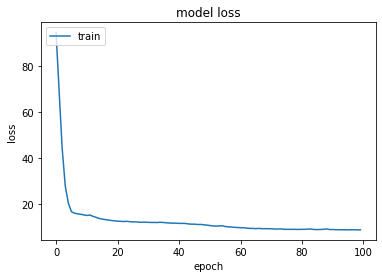

>17.079


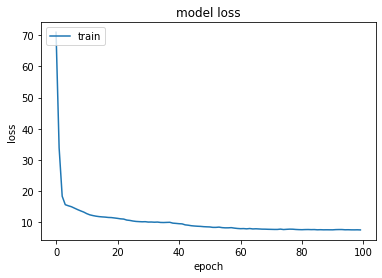

>20.910


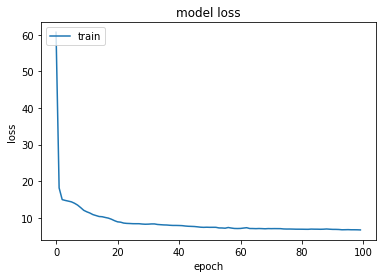

>14.448


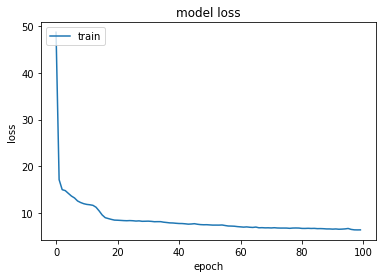

>8.068


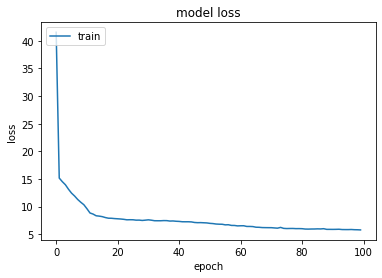

>6.853


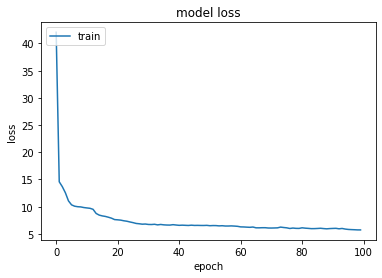

>23.817


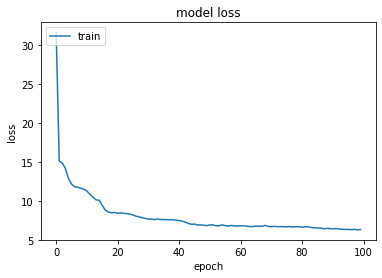

>10.891


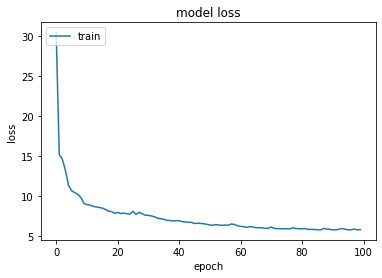

>18.060


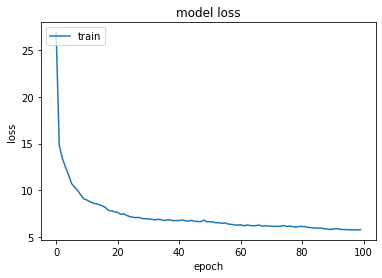

>10.673


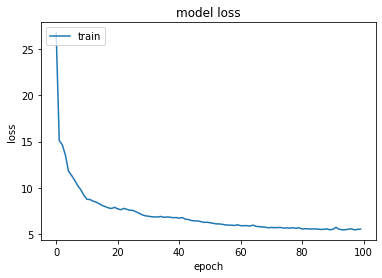

>14.754
MAE: 14.555 (5.242)


In [ ]:
results, yhat = evaluate_model(X, Y)
# summarize performance
print('MAE: %.3f (%.3f)' % (np.mean(results), np.std(results)))

In [ ]:
yhat = np.asarray(yhat)

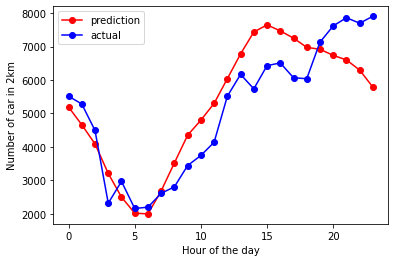

In [ ]:
plt.figure()
time = [x for x in range(24)]
plt.plot(time, yhat[9,505,:], color = 'red', marker='o', label = 'prediction')
plt.plot(time, Y[5608,:], color = 'blue', marker='o', label = 'True')
plt.legend(['prediction', "actual"], loc='upper left')
plt.xlabel('Hour of the day')
plt.ylabel('AQI')
plt.show()

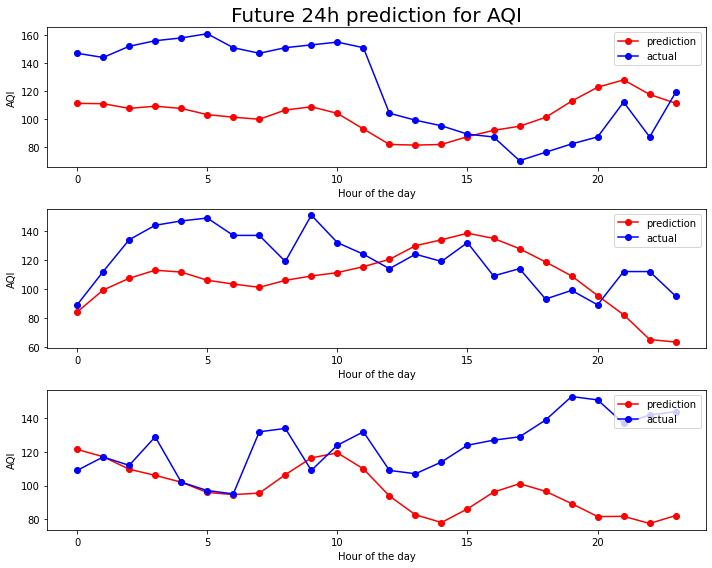

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8)) # (1, 2) inputs say we want 1 row and 2 columns of plots
time = [x for x in range(24)]
for i in range(3):
    x = 506 - 30 * i 
    y = 5609 - 30 * i 
    ax[i].plot(time, yhat[9,x,:], color = 'red', marker='o', label = 'prediction')
    ax[i].plot(time, Y[y,:], color = 'blue', marker='o', label = 'True')
    ax[i].legend(['prediction', "actual"], loc='upper right')
    ax[i].set_xlabel('Hour of the day')
    ax[i].set_ylabel('AQI')

ax[0].title.set_text('Future 24h prediction for AQI')
ax[0].title.set_fontsize(20)
plt.tight_layout()
plt.show()

In [ ]:
data.describe()['aqi']

count    5634.000000
mean       91.886049
std        30.380900
min         3.600000
25%        68.000000
50%        87.000000
75%       112.000000
max       184.000000
Name: aqi, dtype: float64